CONTENTS:
- [Exploratory Data Analysis: FRED Metadata](#exploratory-data-analysis:-fred-metadata)
  - [Introduction](#introduction)
  - [Imports](#imports)
  - [Load Data](#load-data)
    - [Column information](#column-information)
  - [Preprocessing](#preprocessing)
  - [Introductory Analytics](#introductory-analytics)
    - [Missing Data](#missing-data)
    - [Descriptor Analytics](#descriptor-analytics)
    - [Top Data Sources](#top-data-sources)
  - [Data Freshness](#data-freshness)
    - [Start/End Cohorts by Decade](#start/end-cohorts-by-decade)
    - [Discontinued Series](#discontinued-series)
    - [Active/Discontinued by Source](#active/discontinued-by-source)
    - [Top 20 Discontinued by Data Source](#top-20-discontinued-by-data-source)
    - [Top 20 Discontinued by Tag](#top-20-discontinued-by-tag)
    - [Top 20 Discontinued by Category](#top-20-discontinued-by-category)
    - [Frequency of Data](#frequency-of-data)
    - [Base Frequency by Data Source](#base-frequency-by-data-source)
  - [Seasonal Adjustment Analysis](#seasonal-adjustment-analysis)
  - [Analyses on Categories and Tags](#analyses-on-categories-and-tags)
    - [Hierarchical Categorical Analyses](#hierarchical-categorical-analyses)
    - [Tags Distribution](#tags-distribution)
    - [Distribution of Tag Categories](#distribution-of-tag-categories)
    - [Count of Tags and Categories per Series](#count-of-tags-and-categories-per-series)
    - [Top Tags for Each Root Category](#top-tags-for-each-root-category)
  - [Geographical Analysis](#geographical-analysis)
    - [US vs Non-US](#us-vs-non-us)
    - [Breakdown by Continent](#breakdown-by-continent)
    - [Distribution of Data by State](#distribution-of-data-by-state)
  - [Analyses of some Derived Features](#analyses-of-some-derived-features)
    - [Derived Feature Correlation](#derived-feature-correlation)
    - [Duration vs Staleness](#duration-vs-staleness)

<a name='exploratory-data-analysis:-fred-metadata'></a>
# Exploratory Data Analysis: FRED Metadata

<a name='introduction'></a>
## Introduction

This notebook draws statistical insights from the metadata of the Federdal Reserve Economic Database. The goal is to get a full picture of what data is available on FRED, including tag/category distributions, temporal and geographic breakdowns, source comparisons, and more.

<a name='imports'></a>
<a name='import-necessary-packages-and-load-the-metadata'></a>
## Imports

In [1]:
%load_ext autoreload
%autoreload 2
import json

import helpers.hs3 as hs3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import FuncFormatter

import causal_automl.eda_utils as caueduti

# Notebook styling.
sns.set_theme(style="whitegrid")

In [3]:
# Set configurations.
s3_path = "s3://causify-data-collaborators/causal_automl"
fred_path = f"{s3_path}/metadata/fred_series_metadata_v1.0.csv"
country_continent_path = f"{s3_path}/supplemental_data/country_continent.csv"
us_states_path = f"{s3_path}/supplemental_data/us_states.geojson"
# Set top N for bar charts.
N = 20

<a name='load-data'></a>
## Load Data

In [ ]:
# Load the FRED metadata.
s3 = hs3.get_s3fs("ck")
stream = s3.open(fred_path, mode="r")
fred = pd.read_csv(stream, engine="python", on_bad_lines="skip")
# Load country to continent mapper.
with s3.open(country_continent_path) as f:
    cc = pd.read_csv(f)
# Load US state data.
with s3.open(us_states_path, mode="r") as f:
    geo = json.load(f)

In [5]:
print(fred.shape)
print(fred.columns)
fred.head(5)

(642162, 13)
Index(['id', 'title', 'description', 'tags', 'last_updated', 'units',
       'frequency', 'seasonal_adjustment', 'notes', 'categories',
       'data_source', 'start_date', 'end_date'],
      dtype='object')


,id,title,description,tags,last_updated,units,frequency,seasonal_adjustment,notes,categories,data_source,start_date,end_date
0,NROU,Noncyclical Rate of Unemployment,Graph and download economic data for Noncyclic...,nairu; cbo; long-term; projection; unemploymen...,2025-03-17T15:44:00-05:00,Percent,Quarterly,Not Seasonally Adjusted,"Starting with the July, 2021 report:An Update ...","Population, Employment, & Labor Markets",U.S. Congressional Budget Office,1949-01-01,2035-10-01
1,NROUST,Natural Rate of Unemployment (Short-Term) (DIS...,Graph and download economic data for Natural R...,nairu; cbo; short-term; projection; discontinu...,2021-02-01T14:37:00-06:00,Percent,Quarterly,Not Seasonally Adjusted,"This series last appeared in the February, 202...","Population, Employment, & Labor Markets",U.S. Congressional Budget Office,1949-01-01,2031-10-01
2,LNU04032183,Unemployment Rate - Asian,Graph and download economic data for Unemploym...,asian; 16 years +; household survey; unemploym...,2025-03-07T07:46:00-06:00,Percent,Monthly,Not Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",U.S. Bureau of Labor Statistics,2000-01-01,2025-03-01
3,U4RATE,"Total Unemployed Plus Discouraged Workers, as ...",Graph and download economic data for Total Une...,discouraged; labor underutilization; workers; ...,2025-03-07T07:46:00-06:00,Percent,Monthly,Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",U.S. Bureau of Labor Statistics,1994-01-01,2025-03-01
4,LNS14000025,"Unemployment Rate - 20 Yrs. & over, Men",Graph and download economic data for Unemploym...,20 years +; males; household survey; unemploym...,2025-03-07T07:48:00-06:00,Percent,Monthly,Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",U.S. Bureau of Labor Statistics,1948-01-01,2025-03-01


<a name='column-information'></a>
### Column information

| Column                | Description                                                      |
|-----------------------|------------------------------------------------------------------|
| `id`                | Unique FRED series identifier (e.g. “NROU”).                     |
| `title`             | Human‐readable name of the series.                               |
| `description`       | Full text describing what the series measures.                   |
| `tags`              | Semicolon‑separated keywords associated with the series.         |
| `last_updated`      | Timestamp of the most recent metadata update for this series.    |
| `units`             | Units of measurement (e.g. “Percent”, “USD”).                    |
| `frequency`         | Reporting frequency (e.g. “Monthly”, “Quarterly”, etc.).         |
| `seasonal_adjustment` | Indicates whether data are seasonally adjusted (e.g. “SA” or “Not Seasonally Adjusted”). |
| `notes`             | Additional commentary or caveats about the series.               |
| `categories`        | Semicolon‑separated high‑level classification(s) of the series.  |
| `data_source`       | Originating agency or organization that publishes the data.      |
| `start_date`        | Date of the first observation available for the series.          |
| `end_date`          | Date of the last (or most recent forecasted) observation.        |


<a name='preprocessing'></a>
## Preprocessing

In [52]:
fred = caueduti.preprocess_fred(fred, cc)

In [7]:
print(fred.shape)
print(fred.columns)
fred.head(5)

(642162, 31)
Index(['id', 'title', 'description', 'tags', 'last_updated', 'units',
       'frequency', 'seasonal_adjustment', 'notes', 'categories',
       'data_source', 'start_date', 'end_date', 'freq_base', 'tags_list',
       'categories_list', 'n_tags', 'n_categories', 'is_discontinued',
       'staleness_days', 'last_year', 'start_year', 'end_year', 'start_decade',
       'end_decade', 'duration_years', 'country', 'continent', 'title_len',
       'desc_len', 'notes_len'],
      dtype='object')


,id,title,description,tags,last_updated,units,frequency,seasonal_adjustment,notes,categories,...,start_year,end_year,start_decade,end_decade,duration_years,country,continent,title_len,desc_len,notes_len
0,NROU,Noncyclical Rate of Unemployment,Graph and download economic data for Noncyclic...,nairu; cbo; long-term; projection; unemploymen...,2025-03-17 20:44:00,Percent,Quarterly,Not Seasonally Adjusted,"Starting with the July, 2021 report:An Update ...","Population, Employment, & Labor Markets",...,1949.0,2035,1940.0,2030,86.805479,United States of America,North America,32,165,819
1,NROUST,Natural Rate of Unemployment (Short-Term) (DIS...,Graph and download economic data for Natural R...,nairu; cbo; short-term; projection; discontinu...,2021-02-01 20:37:00,Percent,Quarterly,Not Seasonally Adjusted,"This series last appeared in the February, 202...","Population, Employment, & Labor Markets",...,1949.0,2031,1940.0,2030,82.802740,United States of America,North America,56,192,865
2,LNU04032183,Unemployment Rate - Asian,Graph and download economic data for Unemploym...,asian; 16 years +; household survey; unemploym...,2025-03-07 13:46:00,Percent,Monthly,Not Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",...,2000.0,2025,2000.0,2020,25.180822,United States of America,North America,25,174,103
3,U4RATE,"Total Unemployed Plus Discouraged Workers, as ...",Graph and download economic data for Total Une...,discouraged; labor underutilization; workers; ...,2025-03-07 13:46:00,Percent,Monthly,Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",...,1994.0,2025,1990.0,2020,31.183562,United States of America,North America,114,304,103
4,LNS14000025,"Unemployment Rate - 20 Yrs. & over, Men",Graph and download economic data for Unemploym...,20 years +; males; household survey; unemploym...,2025-03-07 13:48:00,Percent,Monthly,Seasonally Adjusted,The series comes from the 'Current Population ...,"Population, Employment, & Labor Markets; Curre...",...,1948.0,2025,1940.0,2020,77.216438,United States of America,North America,39,192,103


<a name='introductory-analytics'></a>
## Introductory Analytics

<a name='missing-data'></a>
### Missing Data

(<Figure size 600x500 with 1 Axes>,
 <Axes: title={'center': '% Missing per Column'}, ylabel='% Missing'>)

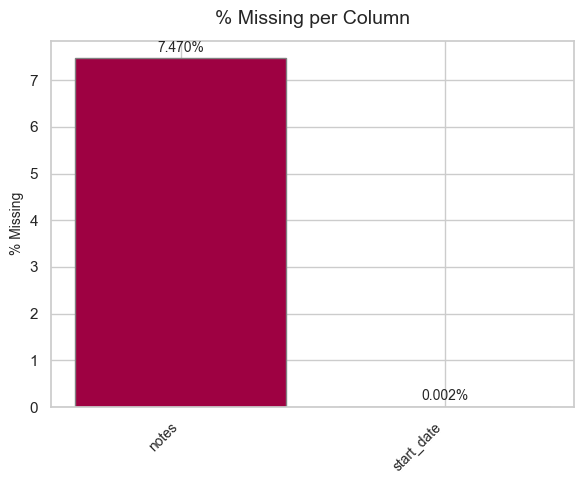

In [8]:
# Prepare data.
original_cols = pd.Index(
    [
        "id",
        "title",
        "description",
        "tags",
        "last_updated",
        "units",
        "frequency",
        "seasonal_adjustment",
        "notes",
        "categories",
        "data_source",
        "start_date",
        "end_date",
    ]
)
miss = fred[original_cols].isna().mean() * 100
miss = miss[miss > 0].sort_values(ascending=False)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=miss,
    total=100,
    top_n=len(miss),
    wrap_width=30,
    figsize=(max(6, len(miss) * 1.2), 5),
    dpi=100,
    xlabel="",
    ylabel="% Missing",
    title="% Missing per Column",
    rotation=45,
    fontsize_title=14,
    fontsize_labels=10,
    fontsize_annotation=10,
    note_prefix="",
    show_coverage_note=False,
    annotation_fmt="{pct:.3f}%",
)

Aside from the optional notes field, the dataset has got essentially full coverage across all other metadata columns—so downstream analyses won’t be materially impacted by missing values.

<a name='descriptor-analytics'></a>
### Descriptor Analytics

(<Figure size 800x500 with 1 Axes>,
 <Axes: title={'center': 'Notes Length Distribution'}, xlabel='Length (characters)', ylabel='Count'>)

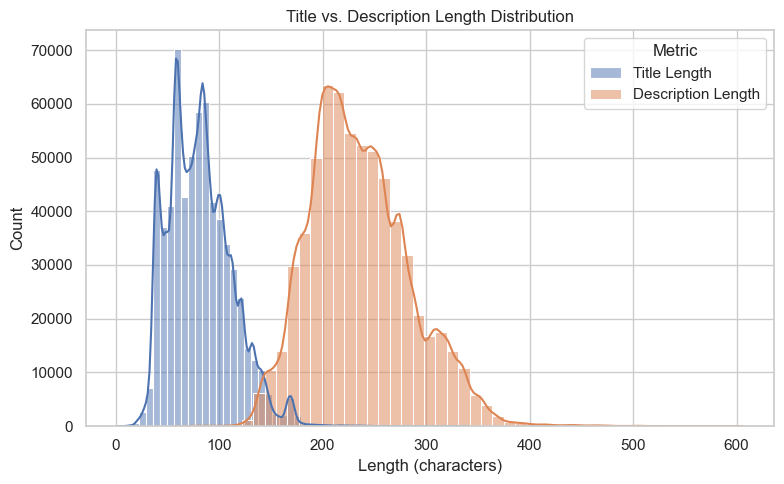

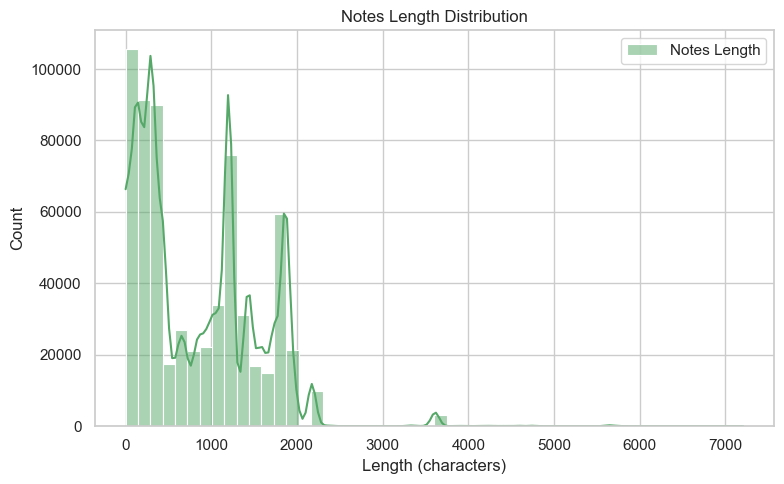

In [9]:


# Plot title and description lengths together.
caueduti.plot_histograms(
    data_series=[fred["title_len"], fred["desc_len"]],
    labels=["Title Length", "Description Length"],
    colors=["C0", "C1"],
    bins=50,
    kde=True,
    figsize=(8, 5),
    xlabel="Length (characters)",
    title="Title vs. Description Length Distribution",
    legend_title="Metric",
)
# Plot notes length separately.
caueduti.plot_histograms(
    data_series=[fred["notes_len"]],
    labels=["Notes Length"],
    colors=["C2"],
    bins=50,
    kde=True,
    figsize=(8, 5),
    xlabel="Length (characters)",
    title="Notes Length Distribution",
    legend_title=None,
)


- **Titles are short and consistent:** Almost all series titles fall between **30–150 characters**, peaking around **70–100 chars**.

- **Descriptions are longer:** Descriptions peak in the **200-250 char** range, with a right‑skew into a **400+ char** tail.

- **Notes are highly variable:** Most notes stay under **2,000 chars**, but a significant number stretch into **multiple‑thousand‑char** territory; combined with ~**7.5% missingness**


<a name='top-data-sources'></a>
### Top Data Sources

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Top 20 Data Sources'}, xlabel='Data Source', ylabel='Series Count'>)

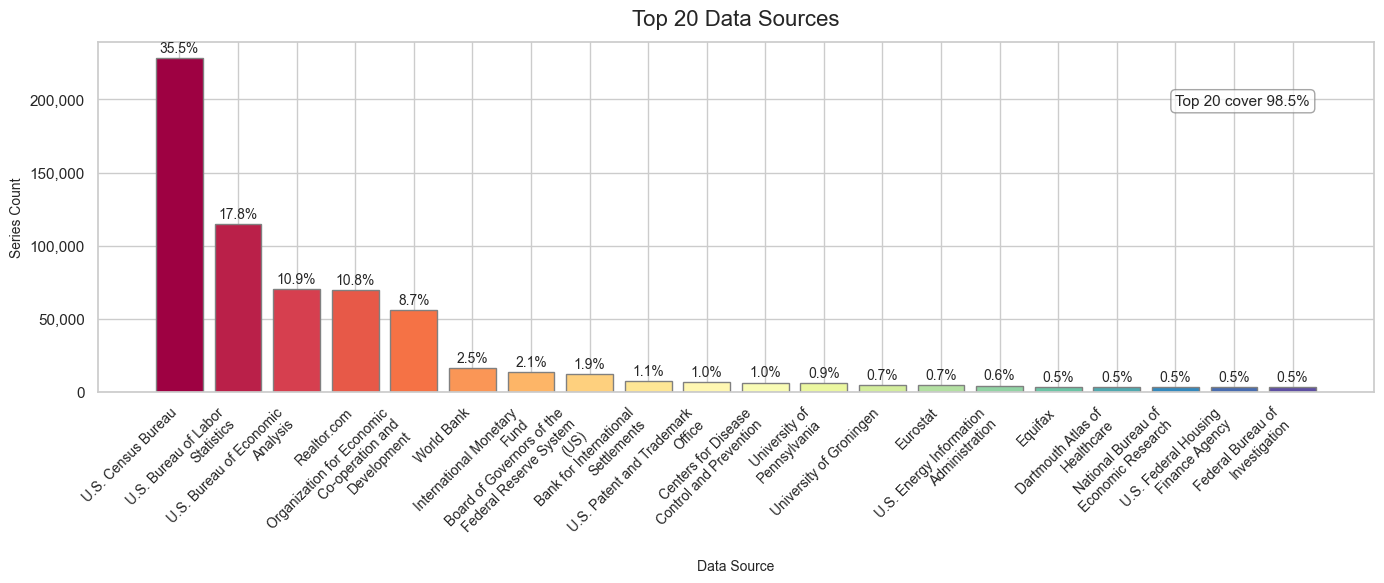

In [10]:
# Prepare data.
src_counts, total = caueduti.prepare_top_counts(fred, "data_source", top_n=20)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=src_counts,
    total=total,
    top_n=20,
    wrap_width=25,
    figsize=(14, 6),
    dpi=100,
    xlabel="Data Source",
    ylabel="Series Count",
    title="Top 20 Data Sources",
    note_prefix="Top {n} cover ",
    note_pos=(0.95, 0.85),
    rotation=45,
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
)

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Coverage vs Top 20 Data Sources'}, xlabel='Top N Data Sources', ylabel='Coverage (%)'>)

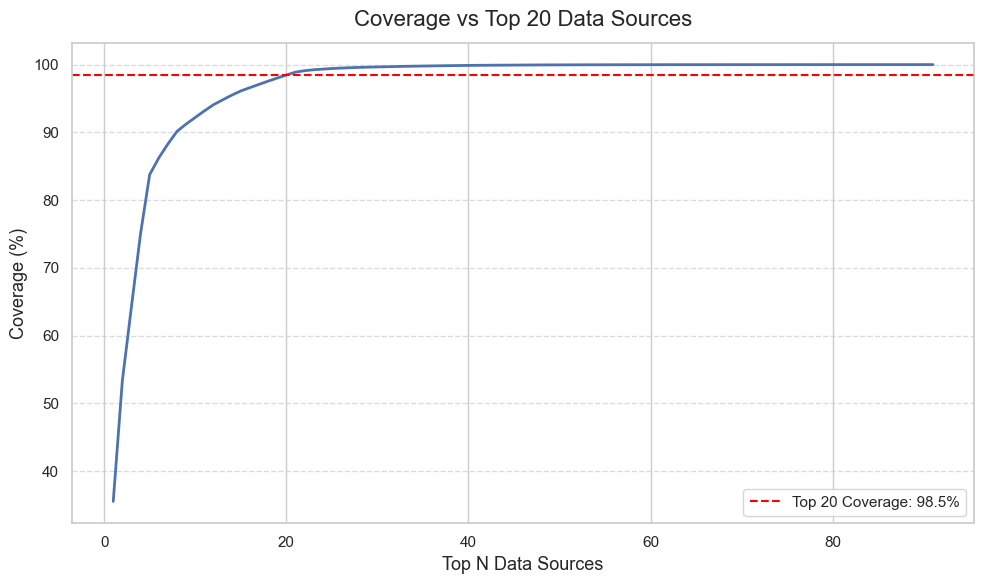

In [12]:
# Coverage.
# Prepare data.
src_counts = fred["data_source"].value_counts()
cum_src_coverage = (
    src_counts.sort_values(ascending=False).cumsum() / src_counts.sum() * 100
)
# Plot.
caueduti.plot_cumulative_coverage(
    cum_coverage=cum_src_coverage,
    cutoff_index=N,
    xlabel="Top N Data Sources",
    ylabel="Coverage (%)",
    title=f"Coverage vs Top {N} Data Sources",
)

- **U.S.‑centric dominance (Unsurprising)**
  The top two sources are both major U.S. agencies: the U.S. Census Bureau (~35.5% of all series) and the Bureau of Labor Statistics (~17.8%). Together they supply over half of the entire database.

- **Heavy skew toward a handful of providers**
  The top five sources (adding the Bureau of Economic Analysis, Realtor.com, and the World Bank) contribute nearly 80% of all series. Beyond those, each additional source accounts for less than 11%.

- **Long but very shallow tail**
  Although 20 sources are shown, after the first handful the individual shares quickly drop below 3% each—and the smallest still make up only about 0.5% apiece.

- **Top 20 cover almost the whole universe**
  These 20 providers account for about **98.5%** of every series in the metadata, meaning there are very few “minor” suppliers beyond this group.

<a name='data-freshness'></a>
## Data Freshness

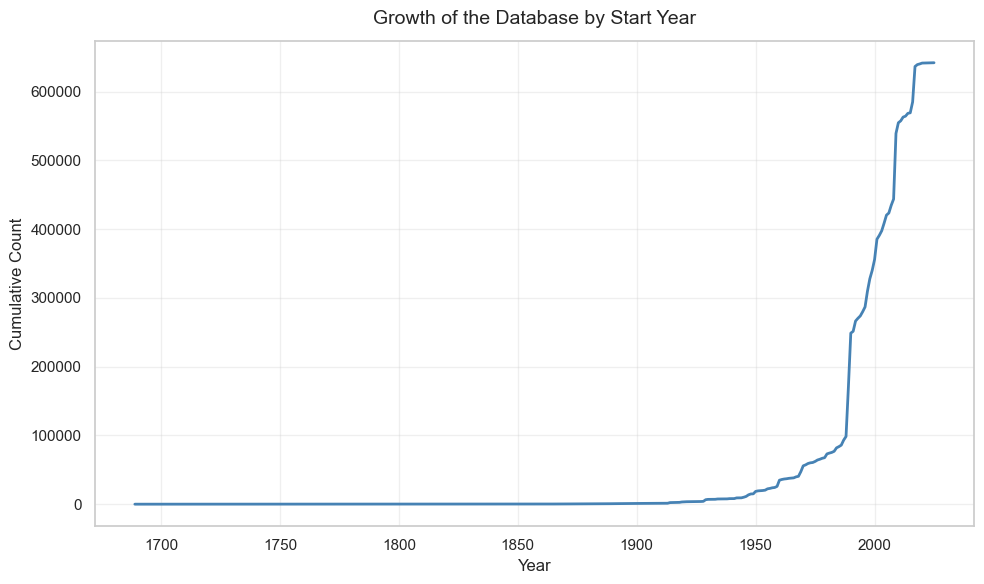

In [13]:
# Prepare data.
cum = fred.groupby("start_year").size().sort_index().cumsum()
# Plot.
caueduti.plot_cumulative_count(
    cum,
    xlabel="Year",
    ylabel="Cumulative Count",
    title="Growth of the Database by Start Year",
    color="steelblue",
    linewidth=2,
    grid_alpha=0.3,
    fontsize_title=14,
    fontsize_labels=12,
)
plt.show()

- **Slow beginnings:** Very little data from 1700 through roughly 1950 were added.
- **Mid‑century pickup:** Between 1950 and 1980 there’s a steady climb, reflecting growing data collection efforts in history.
- **Digital‐era explosion:** After 1980 the curve steepens, and especially post‑2000 it shoots up to over 600 000 series—driven by electronic data releases, globalization of sources, and API availability. The dataset’s breadth is overwhelmingly a product of recent decades; most series are relatively “young.”

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Days Since Last Update'}, xlabel='Staleness (days)', ylabel='Count'>)

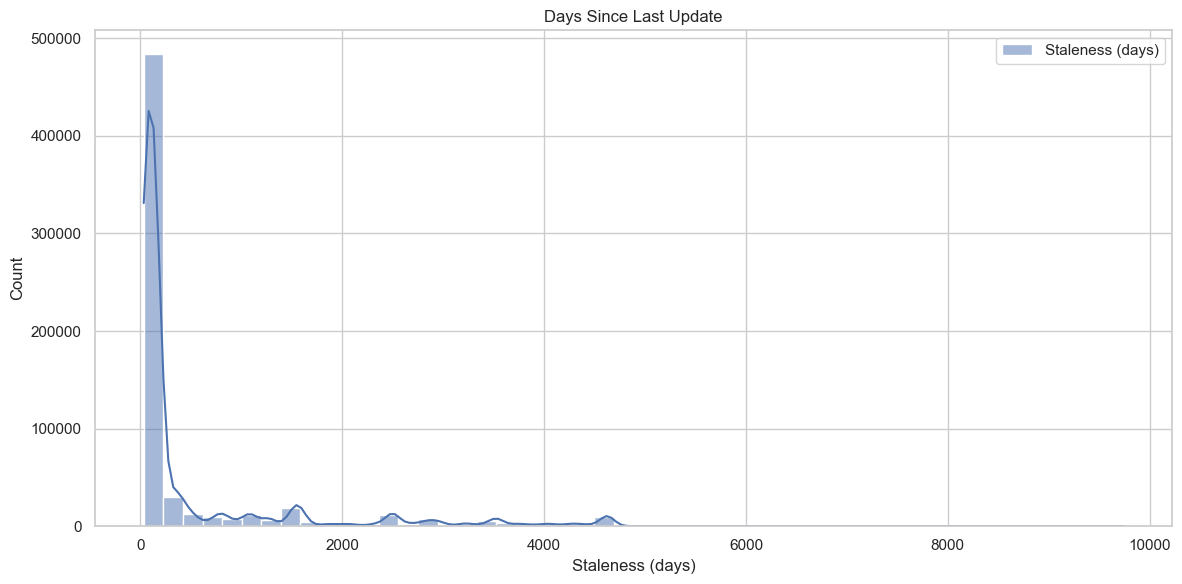

In [14]:
# Plot staleness by days.
# Prepare data.
caueduti.plot_histograms(
    data_series=[fred["staleness_days"]],
    labels=["Staleness (days)"],
    colors=["C0"],
    bins=50,
    kde=True,
    figsize=(12, 6),
    xlabel="Staleness (days)",
    title="Days Since Last Update",
    legend_title=None,
)

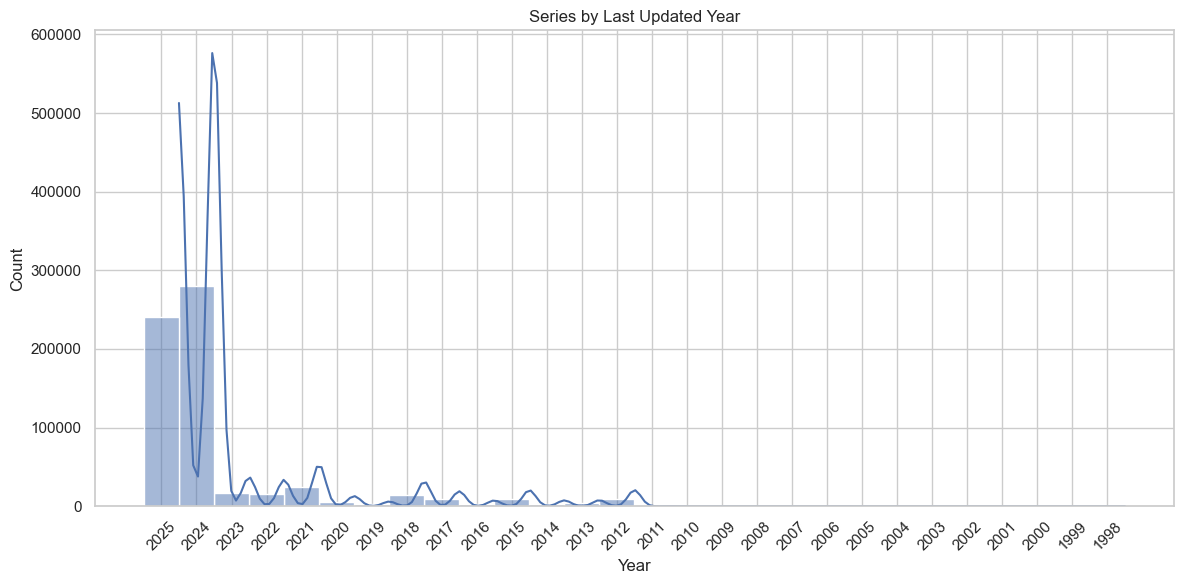

In [15]:

# Prepare data.
years_series = fred["last_year"].dropna().astype(int)
year_min, year_max = years_series.min(), years_series.max()
bin_edges = np.arange(year_min, year_max + 2)
ticks = np.arange(year_min, year_max + 1, 1)
# Plot.
fig, ax = caueduti.plot_histograms(
    data_series=[years_series],
    labels=[""],
    colors=["C0"],
    bins=bin_edges,
    kde=True,
    figsize=(12, 6),
    xlabel="Year",
    title="Series by Last Updated Year",
    legend_title=None,
    xticks=ticks,
    xtick_labels=ticks,
    xticks_shift=0.5,
    xticks_rotation=45,
    invert_xaxis=True,
)
plt.show()


- **Fresh majority:** A huge spike near zero days indicates that most series are updated very recently (e.g. within weeks or months).
- **Heavy tail:** There are a long tail of series with thousands of days since last update—these are largely discontinued or legacy series.
- **But most data remain current, validating FRED as a live data source.**



<a name='start/end-cohorts-by-decade'></a>
### Start/End Cohorts by Decade

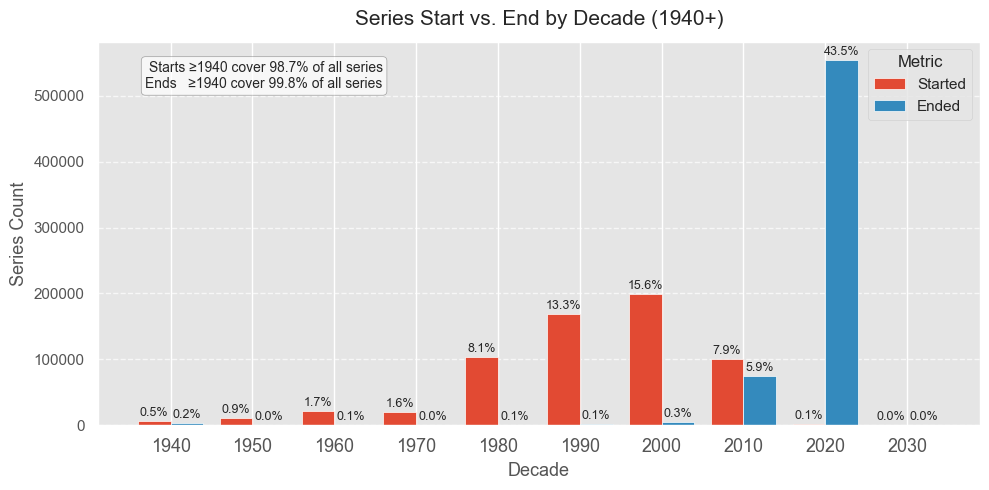

In [51]:
# Prepare Data.
start_counts = fred["start_decade"].value_counts().sort_index()
end_counts = fred["end_decade"].value_counts().sort_index()
df_decade = (
    pd.DataFrame({"Started": start_counts, "Ended": end_counts})
    .fillna(0)
    .astype(int)
)

# Filter to >=1940.
df_plot = df_decade.loc[df_decade.index >= 1940]
categories = df_plot.index.astype(int).tolist()
# Plot.
caueduti.plot_grouped_bars(
    df=df_plot,
    categories=categories,
    series_names=["Started", "Ended"],
    colors=["C0", "C1"],
    xlabel="Decade",
    ylabel="Series Count",
    title="Series Start vs. End by Decade (1940+)",
    legend_title="Metric",
    bar_width=0.4,
    annotation_fmt="{pct:.1f}%",
    figsize=(10, 5),
    dpi=100,
)
# Coverage.
total_started = df_decade["Started"].sum()
total_ended = df_decade["Ended"].sum()
pct_s = df_plot["Started"].sum() / total_started * 100
pct_e = df_plot["Ended"].sum() / total_ended * 100
plt.gca().text(
    0.323,
    0.95,
    f"Starts ≥1940 cover {pct_s:.1f}% of all series\n"
    f"Ends   ≥1940 cover {pct_e:.1f}% of all series",
    transform=plt.gca().transAxes,
    ha="right",
    va="top",
    fontsize=10,
    bbox={"boxstyle": "round,pad=0.3", "fc": "white", "ec": "gray", "alpha": 0.7},
)
plt.show()

(<Figure size 600x500 with 1 Axes>,
 <Axes: title={'center': 'Series with End Date After Today'}, ylabel='Series Count'>)

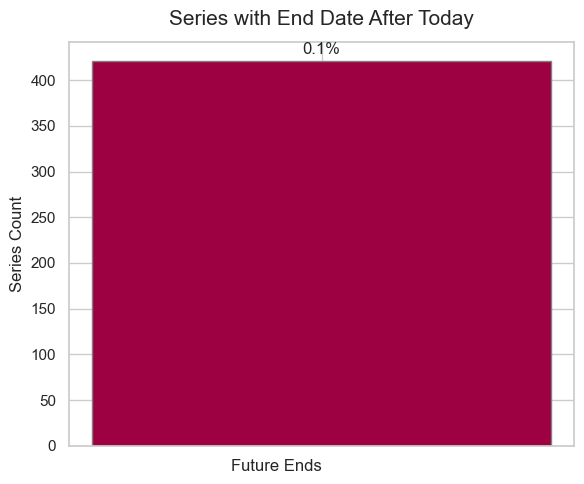

In [17]:
# Prepare data.
today = pd.Timestamp.today().normalize()
future_ends = (fred["end_date"] > today).sum()
total_series = len(fred)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=pd.Series({"Future Ends": future_ends}),
    total=total_series,
    top_n=1,
    wrap_width=None,  # no wrapping needed for single label
    figsize=(6, 5),
    dpi=100,
    xlabel="",  # no x-label
    ylabel="Series Count",
    title="Series with End Date After Today",
    rotation=0,  # vertical label
    fontsize_title=15,
    fontsize_labels=12,
    fontsize_annotation=12,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    show_coverage_note=False,  # omit "Top N cover…" note
)

- **Modern‐Era Focus**
  Over 98% of all series began in 1940 or later, and nearly 75% started between 1980 and 2000, reflecting FRED’s rapid expansion in recent decades.

- **Peak Series Introductions**
  The 2000s saw the highest share of new series (≈31%), followed by the 1990s (≈26%). Earlier decades (1940–1970) each contributed only 1–3%.

- **Tapering New Additions**
  After 2000, the rate of new series slows: the 2010s account for ≈16%, and the 2020s almost none (<1%), suggesting FRED has matured.

- **End‐Date Concentration**
  End dates cluster overwhelmingly in the 2020s (≈86%), indicating most series remain active up through data collected in 2020.

- **Ongoing Data Availability**
  The spike in 2020 end dates implies that the vast majority of series are still maintained beyond that year; very few series have truly “ended.”

<a name='discontinued-series'></a>
### Discontinued Series

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'Active vs. Discontinued Series'}>)

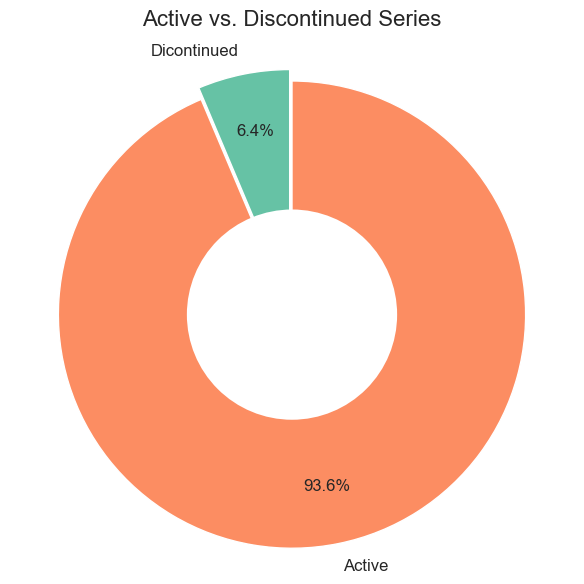

In [18]:
# Prepare data.
labels, sizes = caueduti.get_binary_counts(
    fred, mask=fred["is_discontinued"], labels=["Dicontinued", "Active"]
)
# Plot.
caueduti.plot_donut(
    sizes=sizes, labels=labels, title="Active vs. Discontinued Series"
)

<a name='active/discontinued-by-source'></a>
### Active/Discontinued by Source

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Active vs. Discontinued by Data Source'}, xlabel='Data Source', ylabel='Series Count'>)

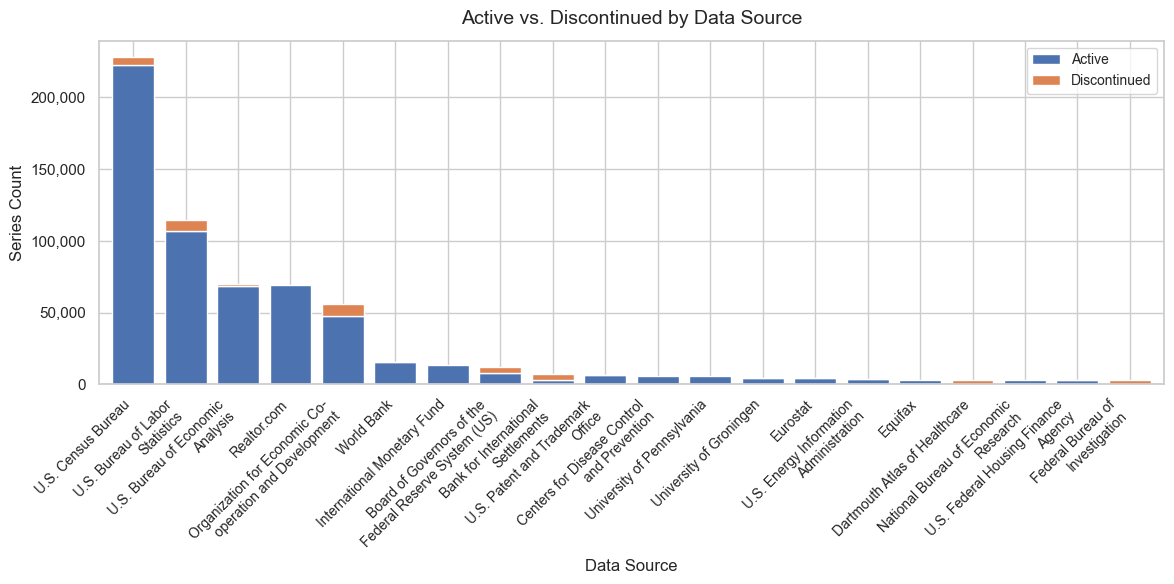

In [19]:
# Prepare data.
ds_top20, labels = caueduti.prepare_crosstab(
    fred,
    index_col="data_source",
    pivot_col="is_discontinued",
    top_n=20,
    wrap_width=30,
)
# Plot.
caueduti.plot_stacked_bar(
    df=ds_top20,
    index_labels=labels,
    xlabel="Data Source",
    ylabel="Series Count",
    title="Active vs. Discontinued by Data Source",
    legend_labels=["Active", "Discontinued"],
    colormap=["C0", "C1"],
)

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Active vs. Discontinued (Non-Dominant Sources)'}, xlabel='Data Source', ylabel='Series Count'>)

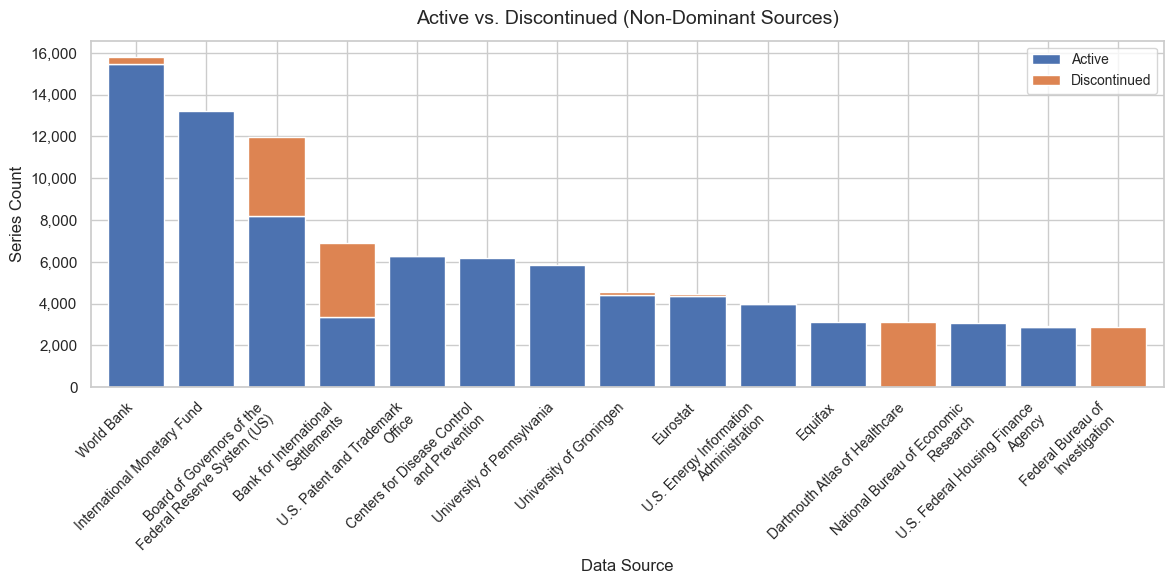

In [20]:
# Prepare data.
nd = ds_top20.index[5:]
ds_nd, labels_nd = caueduti.prepare_crosstab(
    fred,
    index_col="data_source",
    pivot_col="is_discontinued",
    index_list=nd,
    wrap_width=30,
)
# Plot.
caueduti.plot_stacked_bar(
    df=ds_nd,
    index_labels=labels_nd,
    xlabel="Data Source",
    ylabel="Series Count",
    title="Active vs. Discontinued (Non-Dominant Sources)",
    legend_labels=["Active", "Discontinued"],
    colormap=["C0", "C1"],
)

<a name='top-20-discontinued-by-data-source'></a>
### Top 20 Discontinued by Data Source

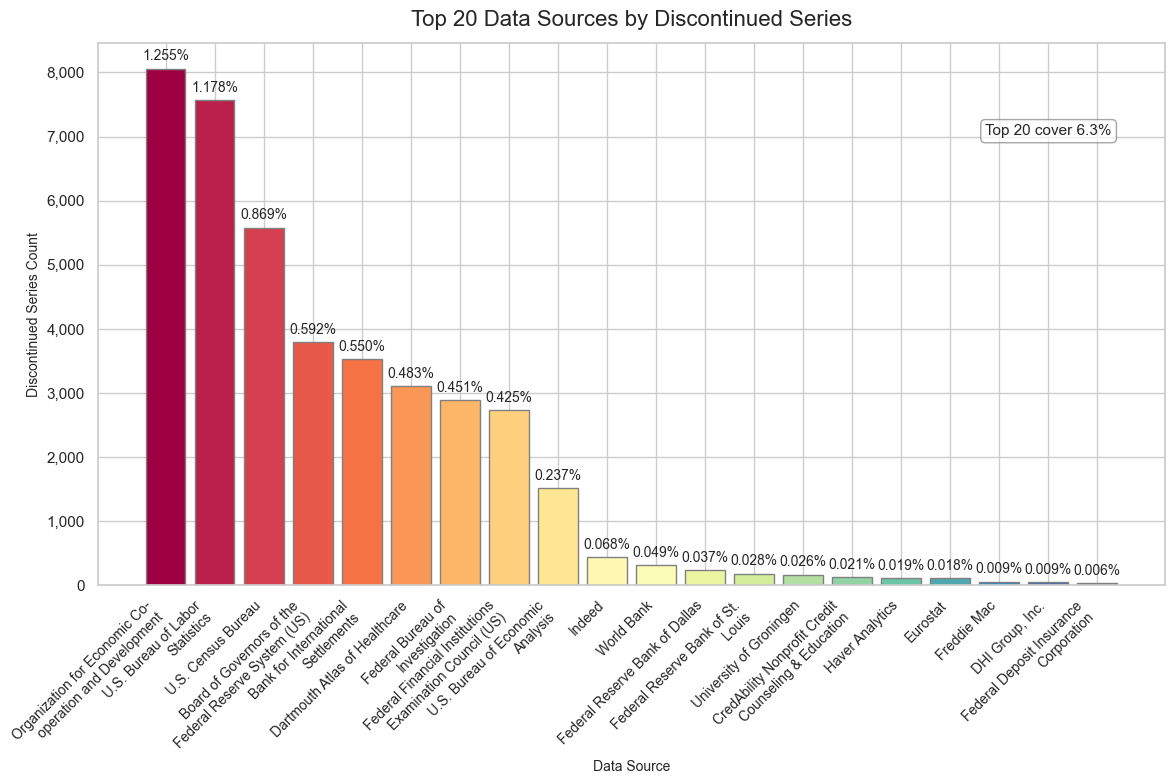

In [21]:
# Prepare data.
disc_src, _ = caueduti.prepare_top_counts(
    fred, "data_source", filter_mask=fred["is_discontinued"], top_n=20
)
# Plot with our reusable function.
fig, ax = caueduti.plot_top_n_annotated_bar(
    counts=disc_src,
    total=total,
    top_n=20,
    wrap_width=30,
    figsize=(12, 8),
    dpi=100,
    xlabel="Data Source",
    ylabel="Discontinued Series Count",
    title=f"Top {20} Data Sources by Discontinued Series",
    rotation=45,
    annotation_fmt="{pct:.3f}%",
    show_coverage_note=True,
)
plt.show()

<a name='top-20-discontinued-by-tag'></a>
### Top 20 Discontinued by Tag

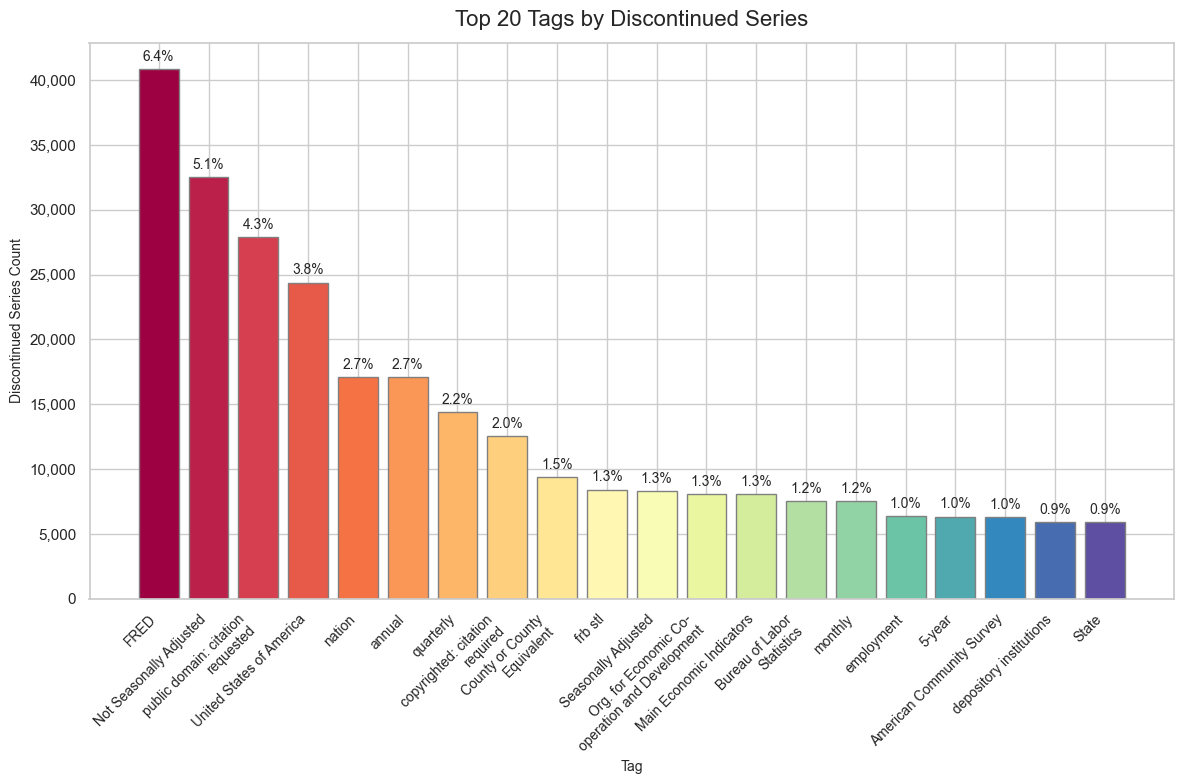

In [22]:
# Prepare data.
disc_tags, _ = caueduti.prepare_top_counts(
    fred,
    "tags_list",
    filter_mask=fred["is_discontinued"],
    explode=True,
    # Drop duplicate tags that show up in the plot.
    drop=[
        "discontinued",
        "federal reserve",
        "fred",
        "nsa",
        "usa",
        "county",
        "bls",
        "acs",
        "St. Louis Fed",
        "mei",
        "oecd",
        "sa",
        "Federal Reserve",
        "Economic Data",
    ],
    top_n=20,
)
# Plot using our reusable function.
fig, ax = caueduti.plot_top_n_annotated_bar(
    counts=disc_tags,
    total=total,
    top_n=N,
    wrap_width=25,
    figsize=(12, 8),
    dpi=100,
    xlabel="Tag",
    ylabel="Discontinued Series Count",
    title=f"Top {N} Tags by Discontinued Series",
    rotation=45,
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    note_prefix=f"Top {N} appear in ",
    show_coverage_note=False,
)

plt.tight_layout()
plt.show()

<a name='top-20-discontinued-by-category'></a>
### Top 20 Discontinued by Category

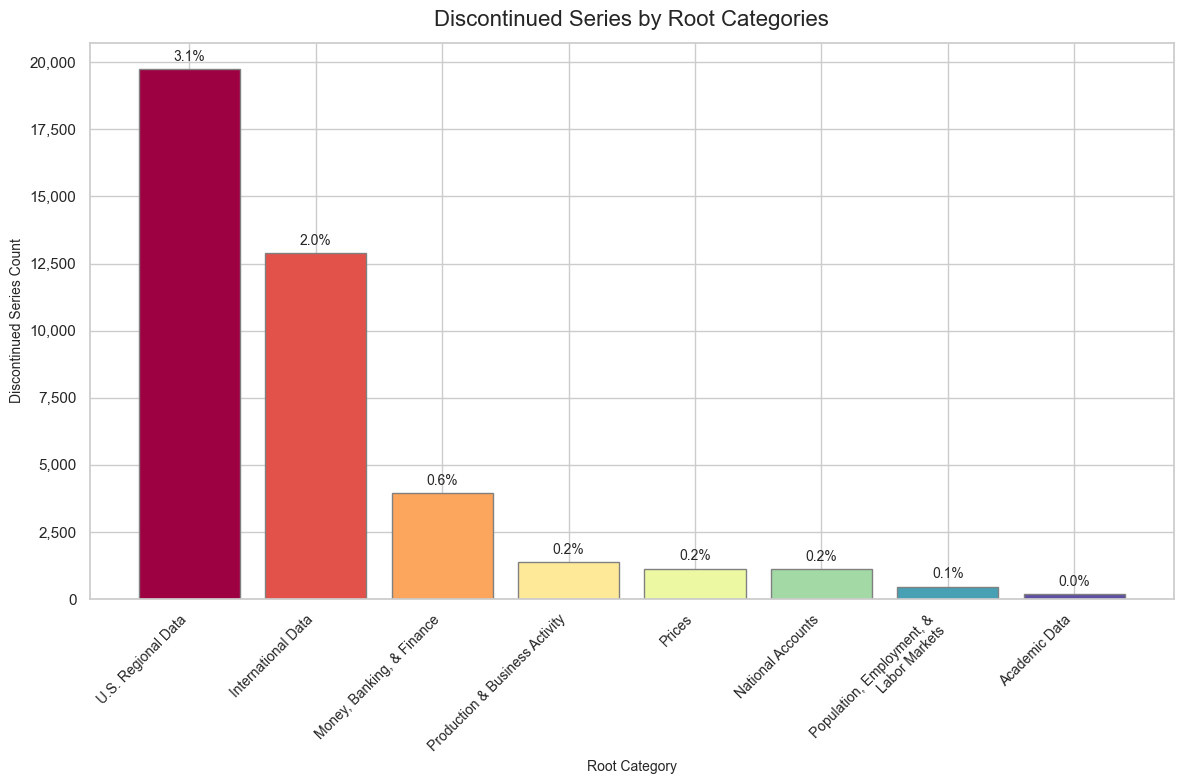

In [23]:

# Prepare data: Root Categories.
disc_root, _ = caueduti.prepare_top_counts(
    fred,
    "categories",
    filter_mask=fred["is_discontinued"],
    split=(";", 0),  # root
    top_n=20,
)
# Plot.
fig, ax = caueduti.plot_top_n_annotated_bar(
    counts=disc_root,
    total=total,
    top_n=N,
    wrap_width=30,
    figsize=(12, 8),
    dpi=100,
    xlabel="Root Category",
    ylabel="Discontinued Series Count",
    title="Discontinued Series by Root Categories",
    rotation=45,
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    note_prefix=f"Top {N} cover ",
    show_coverage_note=False,
)
plt.tight_layout()
plt.show()

**Active vs. Discontinued Series**
- 93.6% of all time series are active
- Only 6.4% remain discontinued

**Active vs. Discontinued by Data Source**
- The U.S. Census Bureau leads with ~220 k active and a small discontinued tail
- The Bureau of Labor Statistics and BEA follow with ~105 k and ~70 k active respectively
- Discontinuations are minimal among the largest sources (<5% of each source’s total)

**Active vs. Discontinued (Non-Dominant Sources)**
- World Bank (~15.4 k active) and IMF (~13.2 k active) show relatively few discontinued series
- Board of Governors of the Federal Reserve System and Bank for International Settlements each have ~8 k active vs ~4 k discontinued
- Dartmouth Atlas of Healthcare and Federal Bureau of Investigation series are almost exclusively discontinued

**Top 20 Data Sources by Discontinued Series**
- OECD (Organization for Economic Cooperation and Development) has the highest discontinued count (~8 k, 1.26%)
- BLS (~7.5 k, 1.18%) and U.S. Census Bureau (~5.6 k, 0.87%) round out the top three
- The top 20 sources account for just 6.3% of all discontinued series

**Top 20 Tags by Discontinued Series**
- “FRED” appears on 6.4% of discontinued series
- “Not Seasonally Adjusted” (5.1%), “public domain: citation requested” (4.3%) and “United States of America” (3.8%) are the next most common tags
- Frequency tags like “annual” and “quarterly” each cover ~2.7% of discontinued series

**Discontinued Series by Root Categories**
- U.S. Regional Data dominates discontinuations (~19.8 k, 3.1%)
- International Data is second (~12.9 k, 2.0%)
- Money, Banking & Finance (~3.9 k, 0.6%) and other categories are far less represented


<a name='frequency-of-data'></a>
### Frequency of Data

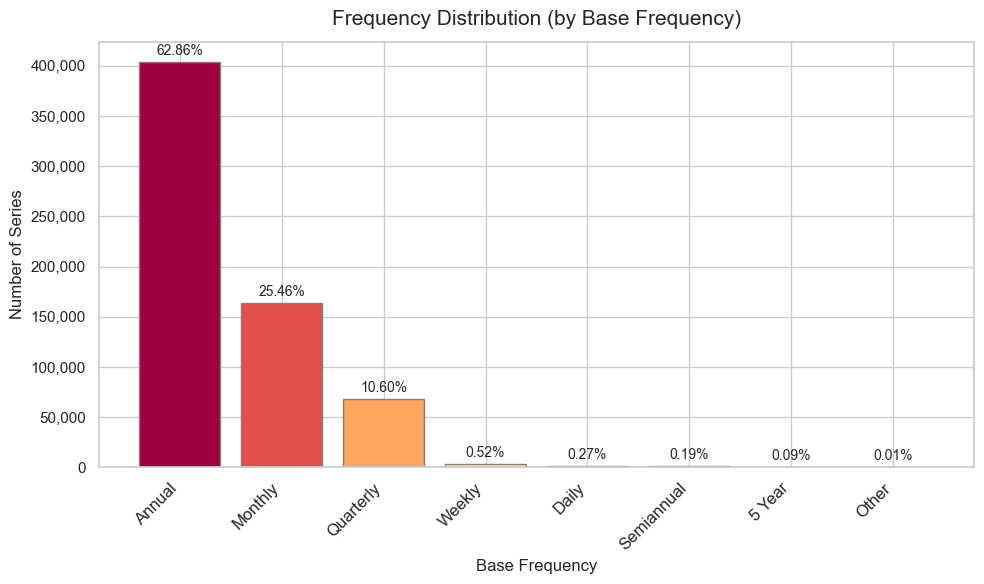

In [24]:
# Prepare Data.
freq_counts, _ = caueduti.prepare_top_counts(
    fred,
    "freq_base",
    threshold=100,
    include_other=False,
)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=freq_counts,
    total=total,
    top_n=len(freq_counts),
    wrap_width=25,
    figsize=(10, 6),
    dpi=100,
    xlabel="Base Frequency",
    ylabel="Number of Series",
    title="Frequency Distribution (by Base Frequency)",
    rotation=45,
    fontsize_title=15,
    fontsize_labels=12,
    fontsize_annotation=10,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    show_coverage_note=False,
    annotation_fmt="{pct:.2f}%",
)
plt.tight_layout()
plt.show()

<a name='base-frequency-by-data-source'></a>
### Base Frequency by Data Source

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Data Source vs. Base Frequency (Top 20)'}, xlabel='Data Source', ylabel='Series Count'>)

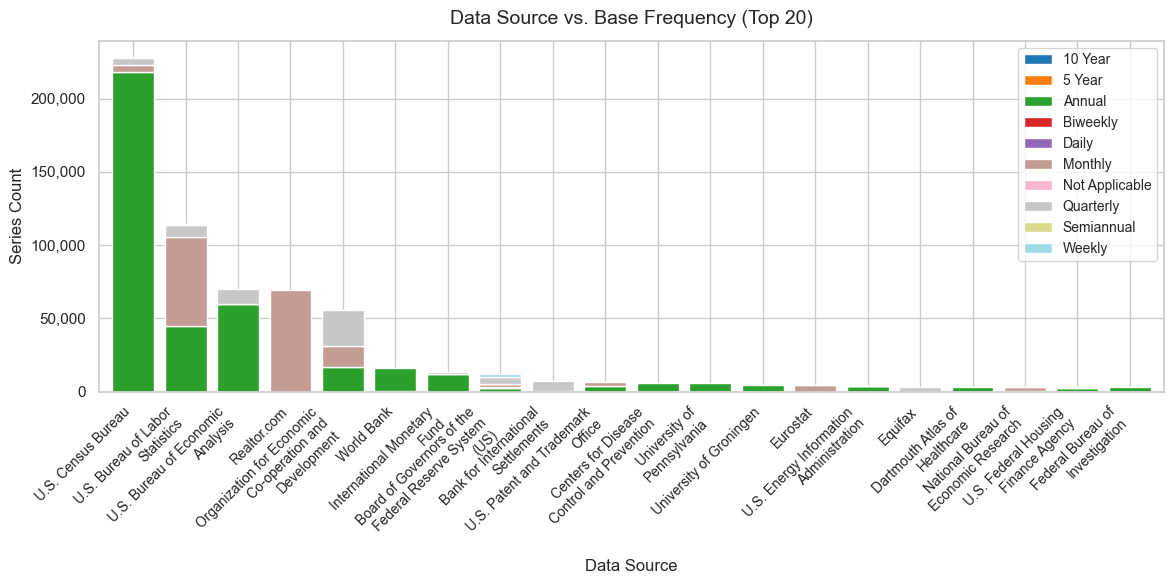

In [25]:
# Prepare data.
ct, labels = caueduti.prepare_crosstab(
    fred, index_col="data_source", pivot_col="freq_base", top_n=20, wrap_width=25
)
# Plot.
caueduti.plot_stacked_bar(
    df=ct,
    index_labels=labels,
    xlabel="Data Source",
    ylabel="Series Count",
    title="Data Source vs. Base Frequency (Top 20)",
    legend_labels=ct.columns.tolist(),
    colormap="tab20",
    width=0.8,
)

(<Figure size 1400x600 with 1 Axes>,
 <Axes: title={'center': 'Data Source vs. Non-Dominant Base Frequencies'}, xlabel='Data Source', ylabel='Series Count'>)

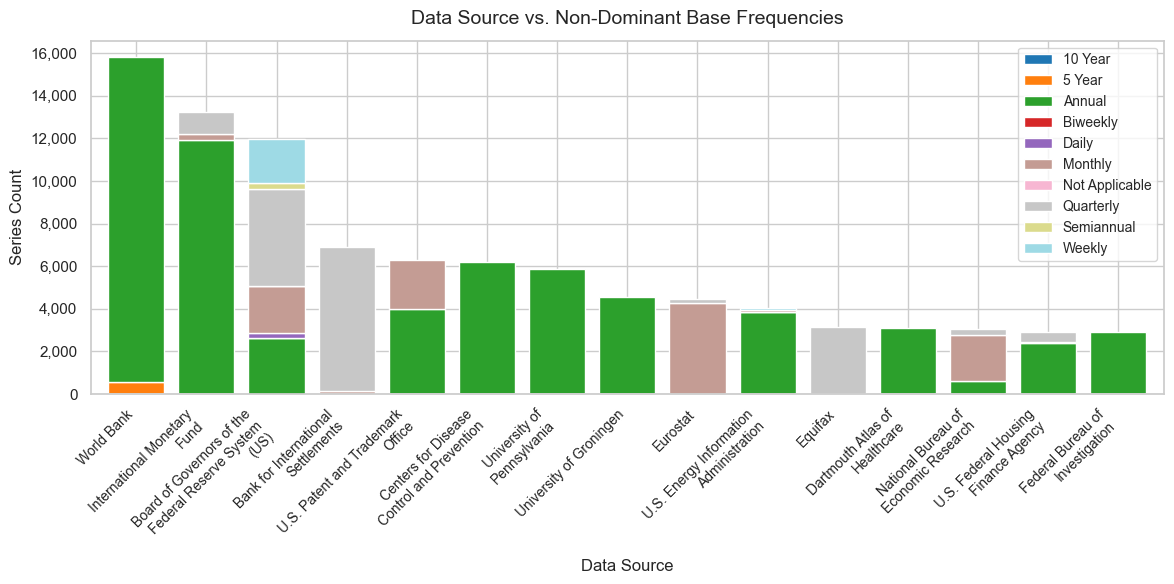

In [26]:
# Prepare data.
top20 = fred["data_source"].value_counts().head(20).index.tolist()
nd15 = top20[5:]
ct_nd, labels_nd15 = caueduti.prepare_crosstab(
    fred,
    index_col="data_source",
    pivot_col="freq_base",
    index_list=nd15,
    wrap_width=25,
)
# Plot.
caueduti.plot_stacked_bar(
    df=ct_nd,
    index_labels=labels_nd15,
    xlabel="Data Source",
    ylabel="Series Count",
    title="Data Source vs. Non-Dominant Base Frequencies",
    legend_labels=ct_nd.columns.tolist(),
    colormap="tab20",
    width=0.8,
)

- **Annual, Monthly & Quarterly dominate**
  The full distribution shows that Annual series account for **62.9%** of all data, Monthly for **25.5%**, and Quarterly for **10.6%**, together covering nearly **99%** of the database.

- **Minor frequencies are vanishingly rare**
  Even when grouping all other types (“Weekly”, “Daily”, “Semiannual”, “5 Year” and “Other”) into a single “Other” bucket, they collectively contribute less than **1%** of the total.

- **Zooming in on the non‑dominant slice**
  Removing Annual and Monthly leaves Weekly as the largest of the remainder at **0.52%**, followed by Daily (**0.27%**), Semiannual (**0.19%**), 5 Year (**0.09%**), and Other (**0.01%**).

- **Long‑tail nature of FRED frequencies**
  A tiny handful of base frequencies drive almost the entire series count, with the remaining frequencies forming a very flat, long tail that individually represent only fractions of a percent.


<a name='seasonal-adjustment-analysis'></a>
## Seasonal Adjustment Analysis

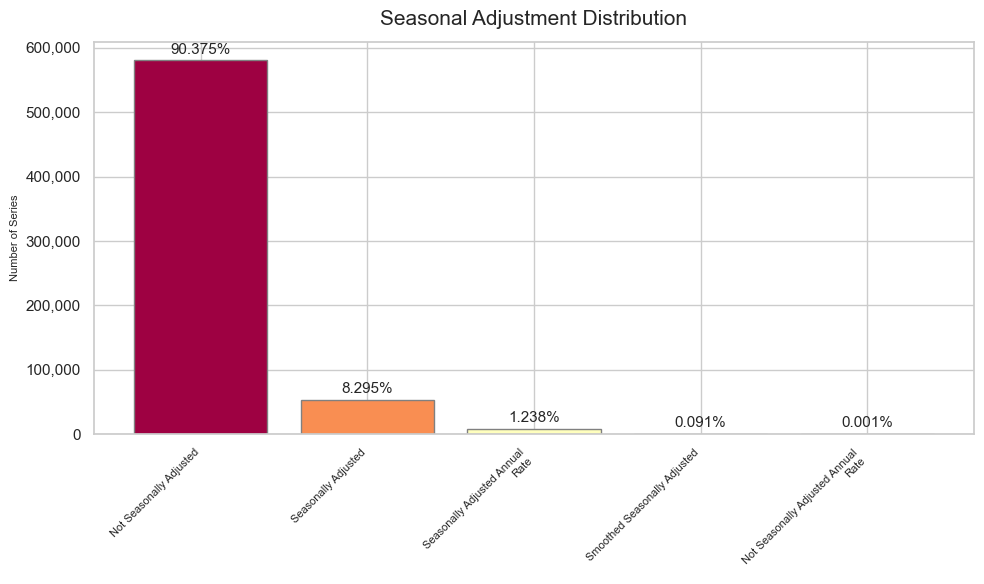

In [27]:
# Prepare data.
sa_counts, _ = caueduti.prepare_top_counts(
    fred, "seasonal_adjustment", top_n=None
)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=sa_counts,
    total=total,
    top_n=len(sa_counts),
    wrap_width=30,
    figsize=(10, 6),
    dpi=100,
    xlabel="",
    ylabel="Number of Series",
    title="Seasonal Adjustment Distribution",
    rotation=45,
    fontsize_title=15,
    fontsize_labels=8,
    fontsize_annotation=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    show_coverage_note=False,
    annotation_fmt="{pct:.3f}%",
)
plt.tight_layout()
plt.show()

- **Overwhelming majority unadjusted** – about 90% of series are published “Not Seasonally Adjusted,” indicating raw data is the default for most indicators.
- **Seasonal adjustment still significant** – roughly 8% of series are adjusted for seasonal effects, reflecting key economic indicators (e.g., employment, inflation) where removing seasonal noise is critical.
- **Annual‐rate adjustments rare** – only about 1.2% use a “Seasonally Adjusted Annual Rate” format, and virtually none (<0.1%) employ smoothed or annual‐rate variants, suggesting specialized use cases.

<a name='analyses-on-categories-and-tags'></a>
## Analyses on Categories and Tags

<a name='hierarchical-categorical-analyses'></a>
### Hierarchical Categorical Analyses

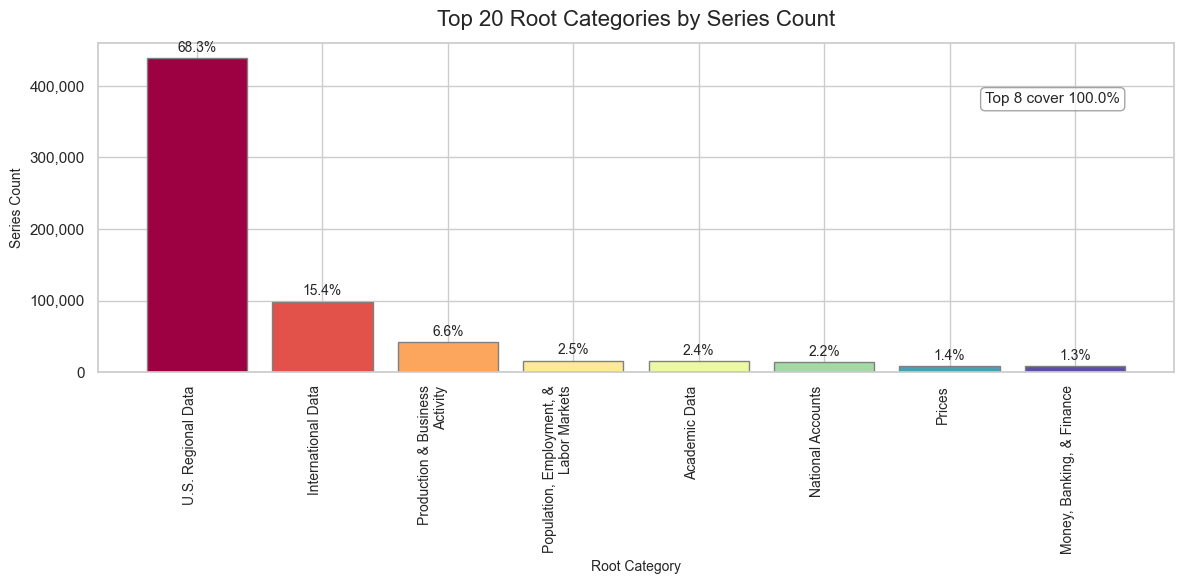

In [28]:
# Prepare data.
root_counts, total_series = caueduti.prepare_top_counts(
    fred, "categories", split=(";", 0), top_n=20
)

# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=root_counts,
    total=total_series,
    top_n=8,
    wrap_width=25,  # wrap long names
    figsize=(12, 6),
    dpi=100,
    xlabel="Root Category",
    ylabel="Series Count",
    title="Top 20 Root Categories by Series Count",
    rotation=90,  # vertical x‐labels
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
)
plt.tight_layout()
plt.show()

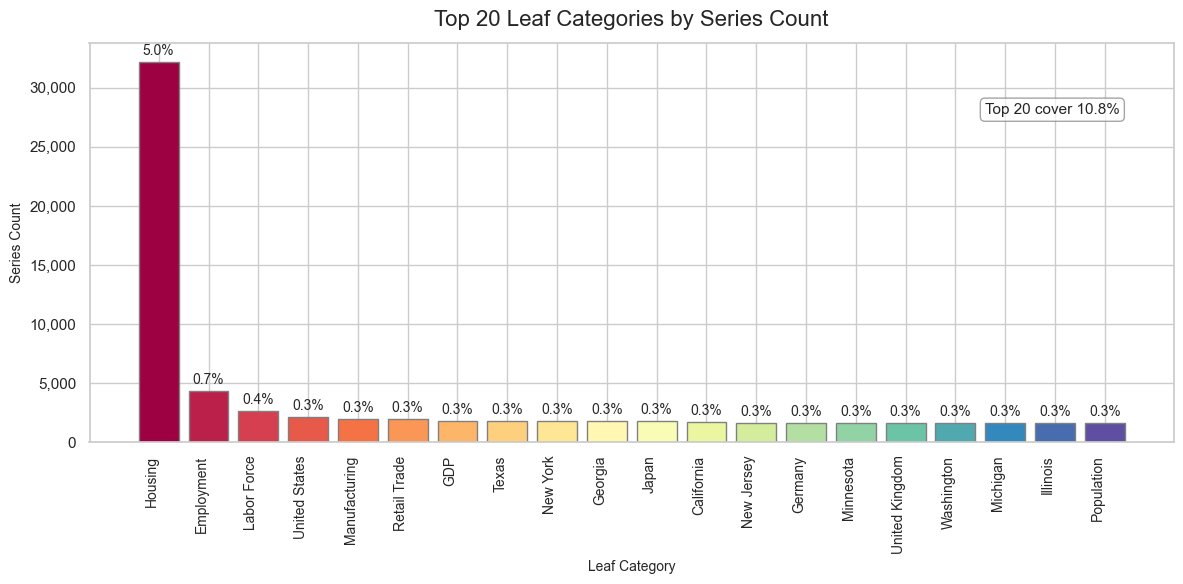

In [29]:
# Prepare data.
leaf_counts, total_series = caueduti.prepare_top_counts(
    fred, "categories", split=(";", -1), top_n=20
)

# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=leaf_counts,
    total=total_series,
    top_n=20,
    wrap_width=25,
    figsize=(12, 6),
    dpi=100,
    xlabel="Leaf Category",
    ylabel="Series Count",
    title="Top 20 Leaf Categories by Series Count",
    rotation=90,
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
)
plt.tight_layout()
plt.show()

In [30]:
# Prepare data.
root_ct, child_ct, grand_ct, total = caueduti.build_category_hierarchy_counts(
    fred["categories"]
)
# Visualize.
caueduti.print_category_hierarchy(root_ct, child_ct, grand_ct, total, top_n=20)

U.S. Regional Data (68.25%)
  ├─ States (66.99%)
    │   ├─ Texas (4.66%)
    │   ├─ Georgia (2.87%)
    │   └─ Others (59.46%)
  ├─ BEA Regions (0.50%)
    │   ├─ Great Lakes (0.06%)
    │   ├─ New England (0.06%)
    │   └─ Others (0.37%)
  └─ Others (0.76%)

International Data (15.36%)
  ├─ Countries (12.53%)
    │   ├─ United States (0.29%)
    │   ├─ Japan (0.28%)
    │   └─ Others (11.97%)
  ├─ Indicators (2.15%)
    │   ├─ Population, Employment, & Labor Markets (1.37%)
    │   ├─ National Accounts (0.35%)
    │   └─ Others (0.44%)
  └─ Others (0.67%)

Production & Business Activity (6.59%)
  ├─ Housing (5.01%)
    │   ├─ Housing Starts (0.00%)
    │   ├─ Housing Units Authorized by Building Permits (0.00%)
    │   └─ Others (5.01%)
  ├─ Industrial Production & Capacity Utilization (0.23%)
    │   ├─ Automotive Production Seasonal Factor (0.00%)
    │   └─ Others (0.23%)
  └─ Others (1.35%)

Population, Employment, & Labor Markets (2.54%)
  ├─ Productivity & Costs (1.48%)
    │ 

<a name='tags-distribution'></a>
### Tags Distribution

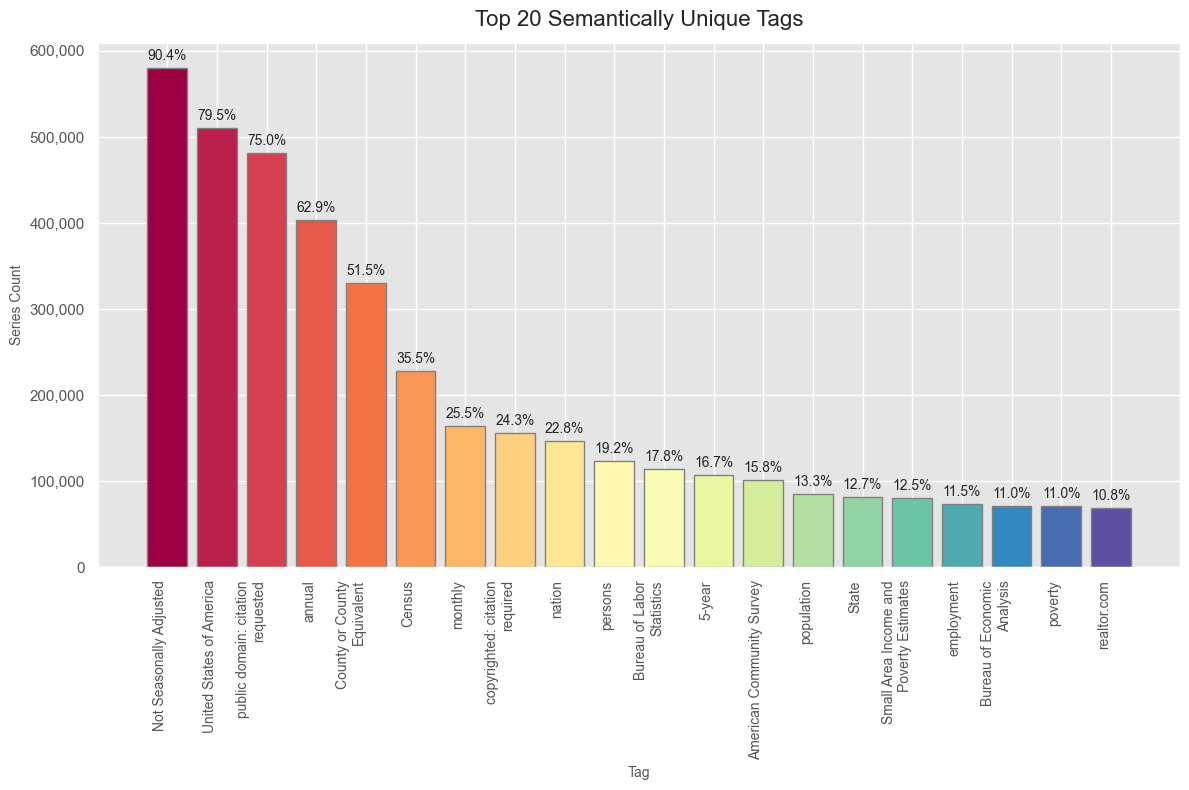

In [54]:
# Prepare data.
tag_counts, total_tags = caueduti.prepare_top_counts(
    fred,
    "tags_list",
    explode=True,
    # Drop duplicate tags that show up in the plot.
    drop=[
        "St. Louis Fed",
        "Federal Reserve",
        "Economic Data",
        "FRED",
        "nsa",
        "usa",
        "county",
        "census",
        "bls",
        "acs",
        "state",
        "Small Area Income &amp",
        "Poverty Estimates",
        "bea",
    ],
    rename={"saipe": "Small Area Income and Poverty Estimates"},
    top_n=N,
)
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=tag_counts,
    total=total,
    top_n=N,
    wrap_width=25,
    figsize=(12, 8),
    dpi=100,
    xlabel="Tag",
    ylabel="Series Count",
    title=f"Top {N} Semantically Unique Tags",
    rotation=90,
    fontsize_title=16,
    fontsize_labels=10,
    fontsize_annotation=10,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    show_coverage_note=False,
)
plt.tight_layout()
plt.show()

<a name='distribution-of-tag-categories'></a>
### Distribution of Tag Categories

OpenAI API call ... 
OpenAI API call done (7.480 s)
OpenAI API call ... 
OpenAI API call done (5.567 s)
OpenAI API call ... 
OpenAI API call done (4.974 s)
OpenAI API call ... 
OpenAI API call done (5.384 s)
OpenAI API call ... 
OpenAI API call done (6.840 s)
OpenAI API call ... 
OpenAI API call done (5.367 s)
OpenAI API call ... 
OpenAI API call done (8.146 s)
OpenAI API call ... 
OpenAI API call done (8.977 s)
OpenAI API call ... 
OpenAI API call done (10.771 s)
OpenAI API call ... 
OpenAI API call done (8.593 s)
OpenAI API call ... 
OpenAI API call done (4.765 s)
OpenAI API call ... 
OpenAI API call done (5.700 s)
OpenAI API call ... 
OpenAI API call done (6.343 s)
OpenAI API call ... 
OpenAI API call done (7.002 s)
OpenAI API call ... 
OpenAI API call done (4.406 s)
OpenAI API call ... 
OpenAI API call done (4.309 s)
OpenAI API call ... 
OpenAI API call done (5.782 s)
OpenAI API call ... 
OpenAI API call done (5.101 s)
OpenAI API call ... 
OpenAI API call done (4.834 s)
OpenAI API 

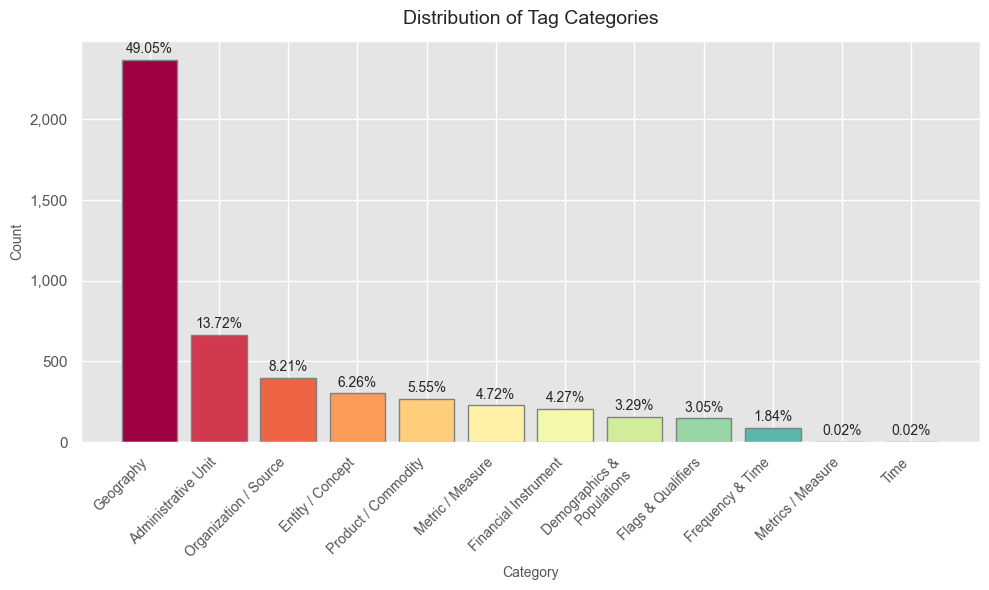

In [53]:
# Prepare data.
model = "gpt-4o-mini"
tag_categories = caueduti.categorize_tags(fred["tags_list"], model)
category_counts = pd.Series(list(tag_categories.values())).value_counts()
# Plot.
fig, ax = caueduti.plot_top_n_annotated_bar(
    counts=category_counts,
    total=category_counts.sum(),
    top_n=len(category_counts),
    wrap_width=25,
    figsize=(10, 6),
    dpi=100,
    xlabel="Category",
    ylabel="Count",
    title="Distribution of Tag Categories",
    rotation=45,
    fontsize_title=14,
    fontsize_labels=10,
    fontsize_annotation=10,
    show_coverage_note=False,
    annotation_fmt="{pct:.2f}%",
)
plt.show()

- **Geographic diversity is highest**
  Nearly half of the tags are geography-related, reflecting a rich variety of locations (countries, states, counties, cities, regions) within the taxonomy.

- **Administrative units also exhibit strong variation**
  Federal Reserve districts, BEA regions, census divisions, etc., form a distant second-largest pool of distinct tags, demonstrating comprehensive coverage of specialized geographies.

<a name='count-of-tags-and-categories-per-series'></a>
### Count of Tags and Categories per Series

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of Categories vs. Tags per Series'}, xlabel='Number per Series', ylabel='Count'>)

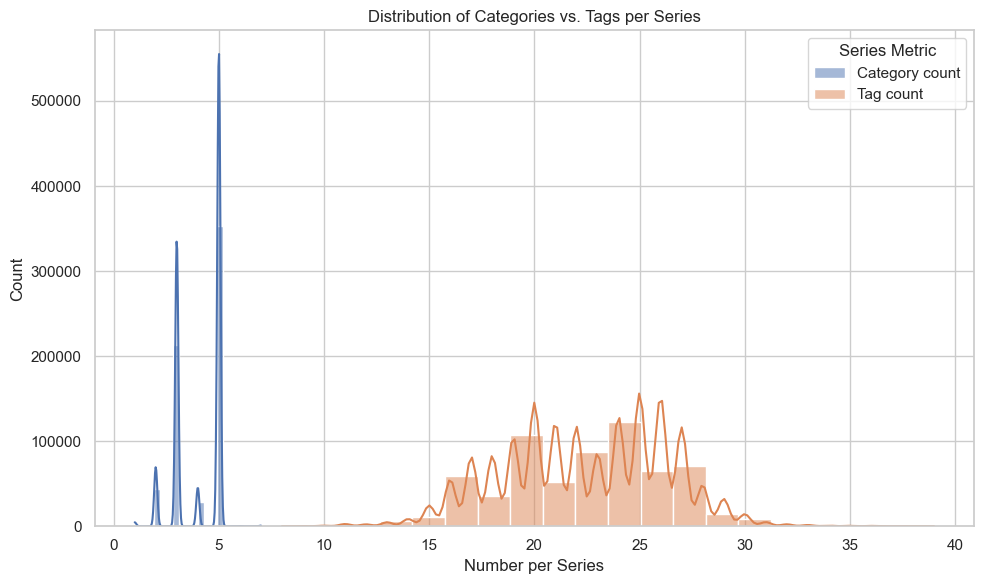

In [33]:
# Plot.
caueduti.plot_histograms(
    data_series=[fred["n_categories"], fred["n_tags"]],
    labels=["Category count", "Tag count"],
    colors=["C0", "C1"],
    bins=20,
    kde=True,
    figsize=(10, 6),
    xlabel="Number per Series",
    title="Distribution of Categories vs. Tags per Series",
    legend_title="Series Metric",
)

- **Categories are very coarse**
  Most FRED series fall into just 1–6 categories (with a clear spike around 4–5), indicating that the category hierarchy is relatively shallow.

- **Tags are far more granular**
  Tag counts per series cluster around 20–25 and extend past 35, showing that FRED uses tags to capture much finer detail.

<a name='top-tags-for-each-root-category'></a>

### Top Tags for Each Root Category

In [45]:
# Drop duplicate tags that show up in the plot.
REDUNDANT = {
    "Federal Reserve",
    "Economic Data",
    "FRED",
    "nsa",
    "usa",
    "county",
    "census",
    "bls",
    "acs",
    "state",
    "Small Area Income &amp",
    "Poverty Estimates",
    "ppp",
    "pwt",
    "oecd",
    "mei",
    "bea",
    "gdp",
    "nipa",
    "upenn",
    "St. Louis Fed",
    "sa",
    "naics",
    "indexes",
}
top10 = caueduti.get_top_tags_by_root(
    df=fred,
    categories_col="categories",
    tags_col="tags_list",
    redundant=REDUNDANT,
    top_n=10,
)

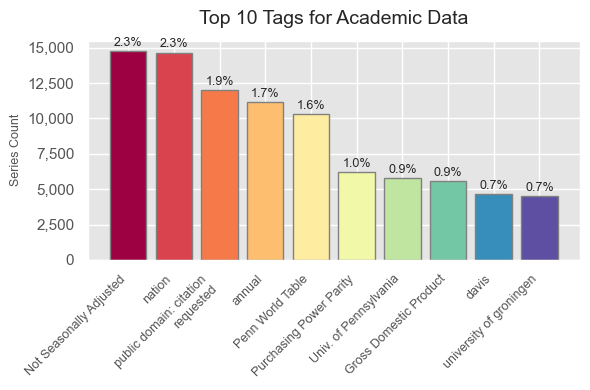

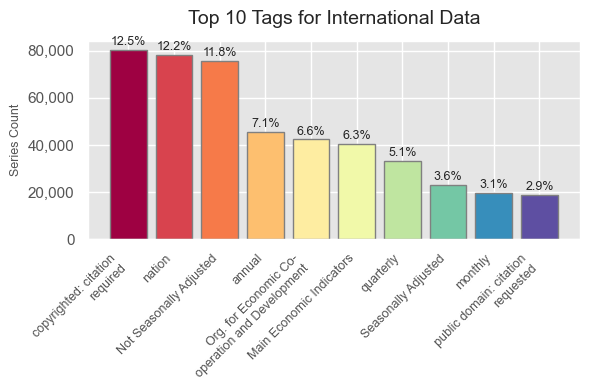

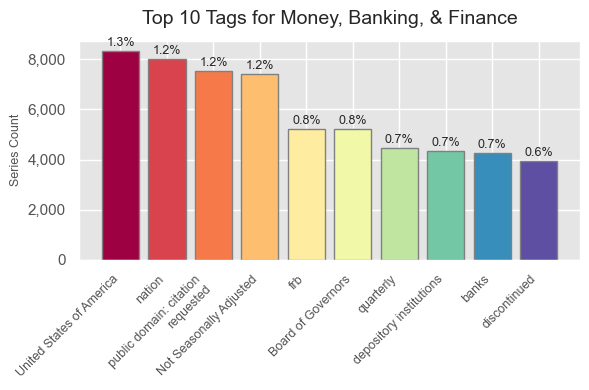

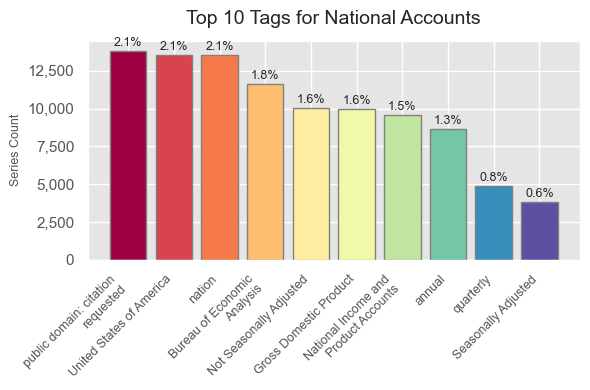

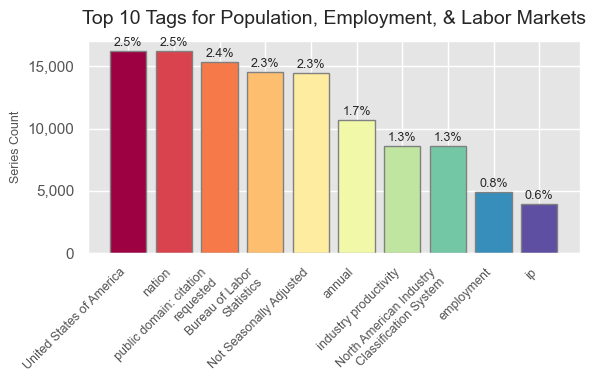

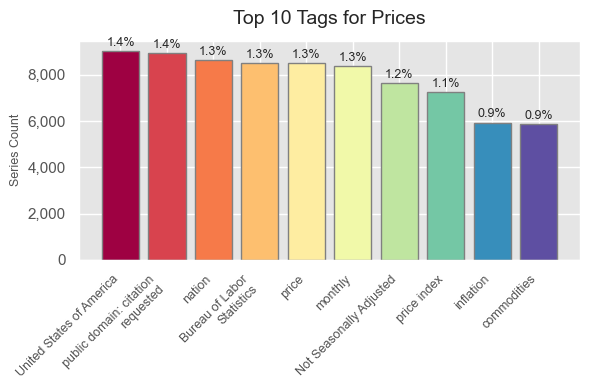

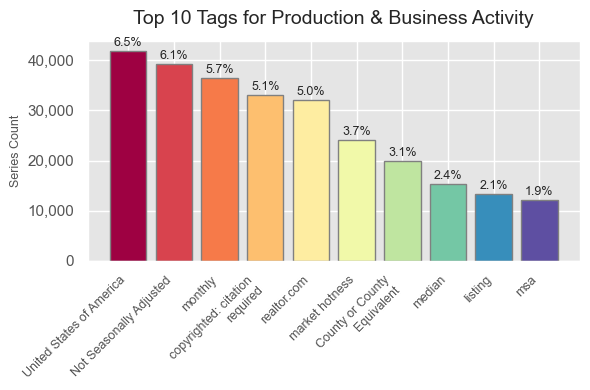

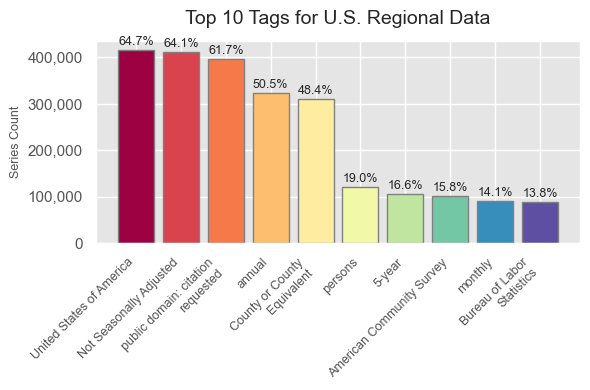

In [46]:

# Compute total tag‐counts per root (for coverage %).
root_totals = top10.groupby("root")["count"].sum()
# For each root, pull out its top‐10 tags.
for root, grp in top10.groupby("root"):
    s = grp.set_index("tag")["count"]
    total_for_root = root_totals[root]
    fig, ax = caueduti.plot_top_n_annotated_bar(
        counts=s,
        total=total,
        top_n=len(s),
        wrap_width=25,
        cmap=plt.cm.Spectral,
        figsize=(6, 4),
        dpi=100,
        xlabel="",
        ylabel="Series Count",
        title=f"Top 10 Tags for {root}",
        rotation=45,
        fontsize_title=14,
        fontsize_labels=9,
        fontsize_annotation=9,
        annotation_fmt="{pct:.1f}%",
        show_coverage_note=False,
        note_prefix="Top 10 cover ",
    )
    plt.show()

- **U.S. Regional Data** exhibits extreme concentration: the top five tags account for a majority of all entries, underscoring a heavy reliance on geographic, licensing and annual metadata.
- **Core metadata qualifiers**—“United States of America”, “public domain: citation requested”, “Not Seasonally Adjusted”—recur across nearly every domain, reflecting standardized categorization practices.
- **Prices** is notably diverse: with the top 10 tags evenly being used.
- **National Accounts** align closely with a single provider (“Bureau of Economic Analysis”) and domestic focus (“United States of America”).



<a name='geographical-analysis'></a>
## Geographical Analysis

<a name='us-vs-non-us'></a>
### US vs Non-US

(<Figure size 600x600 with 1 Axes>,
 <Axes: title={'center': 'US vs Non-US Data'}>)

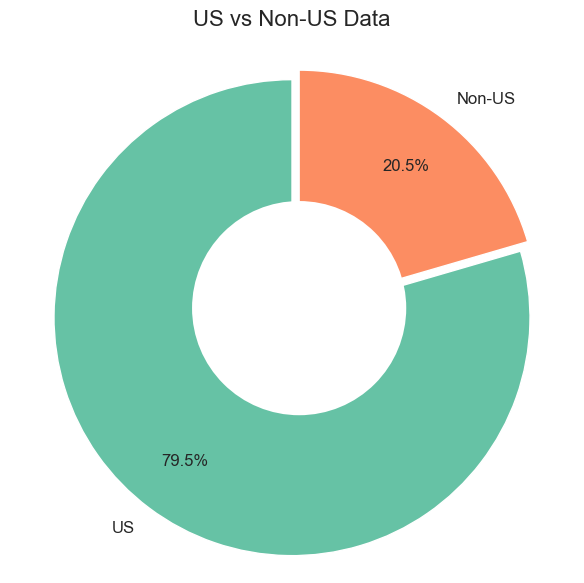

In [36]:

# Prepare data.
labels, sizes = caueduti.get_binary_counts(
    fred,
    pattern=r"\b(?:usa|united states of america)\b",
    search_cols=["tags", "categories", "title", "description", "notes"],
    labels=["US", "Non-US"],
)
# Plot.
caueduti.plot_donut(sizes=sizes, labels=labels, title="US vs Non-US Data")

<a name='breakdown-by-continent'></a>
### Breakdown by Continent

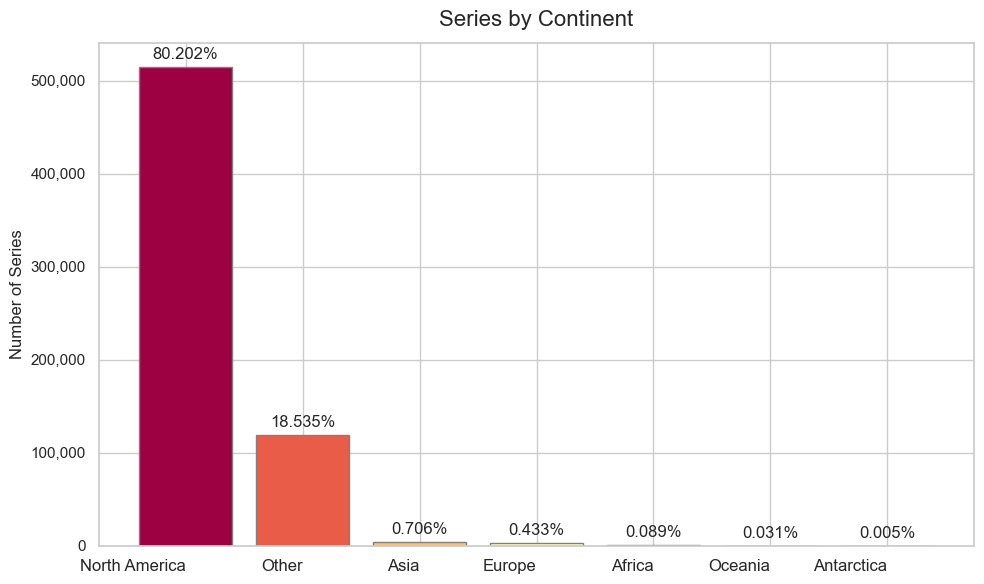

In [37]:
# Prepare data.
cont_counts, total_cont = caueduti.prepare_top_counts(fred, "continent")
# Plot.
caueduti.plot_top_n_annotated_bar(
    counts=cont_counts,
    total=total,
    top_n=len(cont_counts),
    wrap_width=None,
    figsize=(10, 6),
    dpi=100,
    xlabel="",
    ylabel="Number of Series",
    title="Series by Continent",
    rotation=0,
    fontsize_title=16,
    fontsize_labels=12,
    fontsize_annotation=12,
    fontsize_note=11,
    formatter=FuncFormatter(lambda y, pos: f"{int(y):,}"),
    show_coverage_note=False,
    annotation_fmt="{pct:.3f}%",
)
plt.tight_layout()
plt.show()

- **Asia Second**

  Besides North America, the most data recorded pertains to Asia, which is a distant second.

<a name='distribution-of-data-by-state'></a>
### Distribution of Data by State

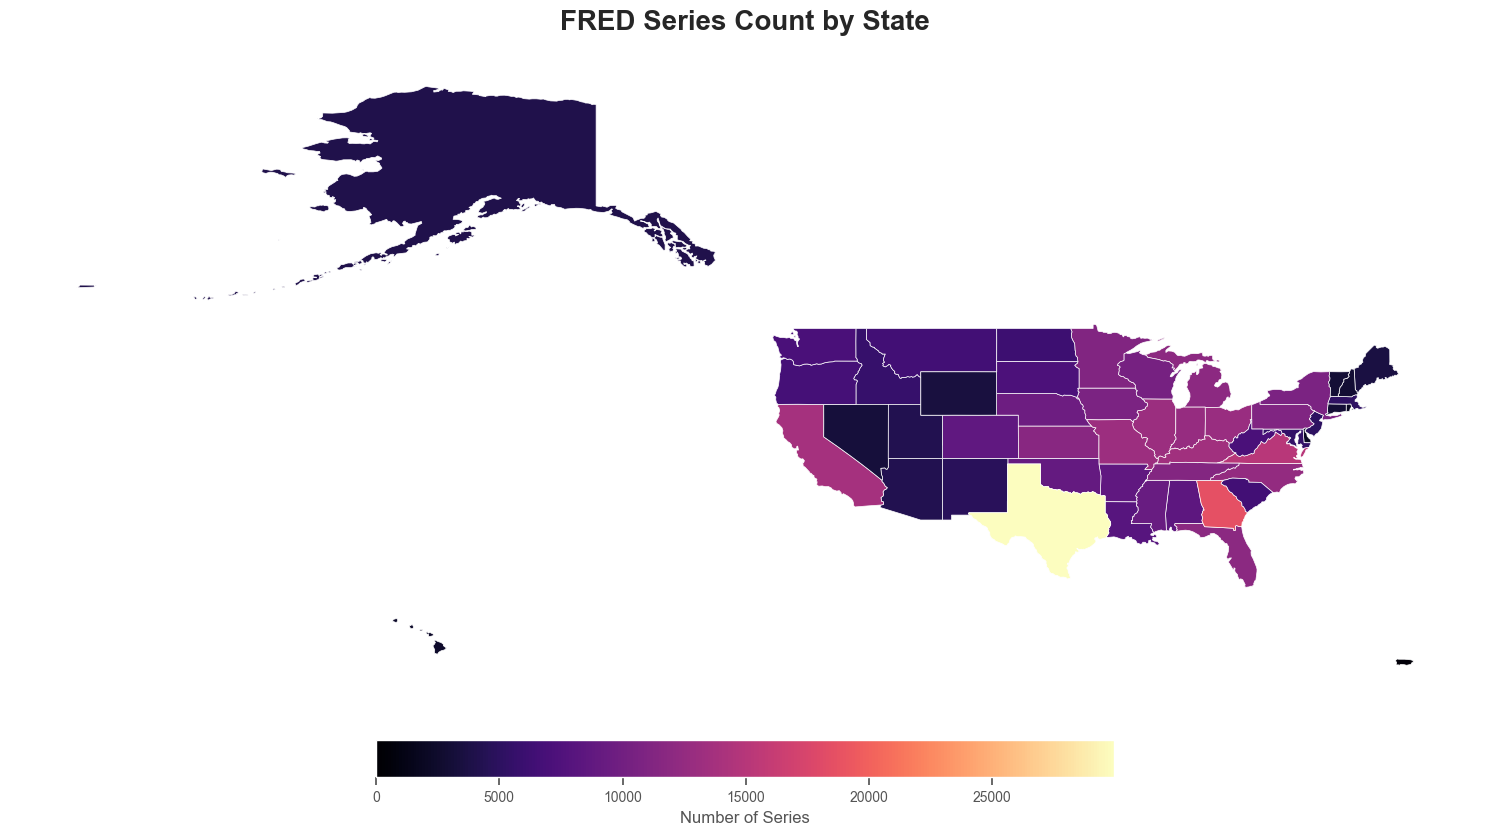

In [47]:
# Compute patches and values using the helper function.
patches, values = caueduti.get_patches_and_values(geo, fred)
# Plot choropleth.
fig, ax = caueduti.plot_choropleth_map(
    patches=patches,
    values=values,
    cmap="magma",
    cbar_label="Number of Series",
    title="FRED Series Count by State",
    title_kwargs={"fontsize": 20, "fontweight": "bold", "pad": 20},
)
plt.show()

- **Texas Leads by a Wide Margin**
  Texas stands out with nearly **30,000** series — far more than any other state — reflecting its large and diverse regional datasets.

- **Strong Coverage in Major Economies**
  California (~15K), New York (≈14K), Florida (≈12K) and Georgia (≈20K) all rank in the top tier, consistent with their population size and economic complexity.

- **Moderate Coverage Across the Midwest & Northeast**
  States like Illinois, Ohio, Pennsylvania, Massachusetts and Michigan each host between **8,000–12,000** series, showing solid but less extreme coverage.

- **Sparse Coverage in Rural & Mountain States**
  Many interior and mountain states (e.g., Wyoming, North Dakota, South Dakota, Montana, Vermont) fall below **5,000** series, highlighting regional gaps.

- **Minimal Series in Alaska & Hawai‘i**
  Both non‑contiguous states appear at the low end (< 3,000 series), reflecting fewer localized time‐series data available for those geographies.

Overall, the map shows that FRED’s series are heavily concentrated in the country’s largest and most economically active states, with tapering coverage as populations and economic activity decrease.

<a name='analyses-of-some-derived-features'></a>
## Analyses of some Derived Features

<a name='derived-feature-correlation'></a>
### Derived Feature Correlation

(<Figure size 800x600 with 2 Axes>,
 <Axes: title={'center': 'Correlation Matrix'}>)

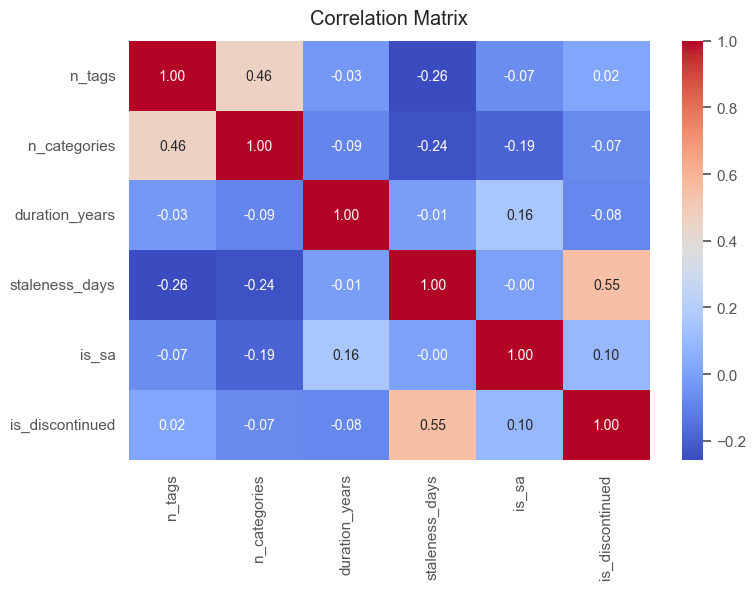

In [39]:
# Prepare data.
num = fred[["n_tags", "n_categories", "duration_years", "staleness_days"]].copy()
num["is_sa"] = (fred["seasonal_adjustment"] != "Not Seasonally Adjusted").astype(
    int
)
num["is_discontinued"] = fred["is_discontinued"].astype(int)
corr = num.corr()
# Plot.
caueduti.plot_heatmap(
    matrix=corr,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    figsize=(8, 6),
    title="Correlation Matrix",
)

- **Tags & Categories Go Hand‑in‑Hand**
  The number of tags and number of categories a series has are moderately positively correlated (≈ 0.46), suggesting richer metadata tends to appear in tandem.

- **Discontinuation Tracks Staleness**
  “Days since last update” shows a strong positive correlation (≈ 0.55) with the `is_discontinued` flag—series that haven’t been refreshed in a long time are much more likely to be discontinued.

- **Seasonal Adjustment ↔ Longer Durations**
  There’s a small but notable positive link (≈ 0.16) between being seasonally adjusted and having a longer overall span, reflecting that many long‑running datasets apply seasonal filters.

- **Older Series Lose Metadata**
  Slight negative correlations of staleness with both tag count (≈ –0.26) and category count (≈ –0.24) indicate that older, less‑recently updated series tend to accumulate fewer descriptive tags/categories over time.

- **Duration is Largely Independent**
  Total duration in years has near‐zero correlations with both discontinuation and staleness, implying that simply having a long or short history doesn’t by itself predict whether a series is up‑to‑date or active.

<a name='duration-vs-staleness'></a>
### Duration vs Staleness

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Duration (years) vs. Staleness (days) (Active Series)'}, xlabel='Duration (years)', ylabel='Staleness (days)'>)

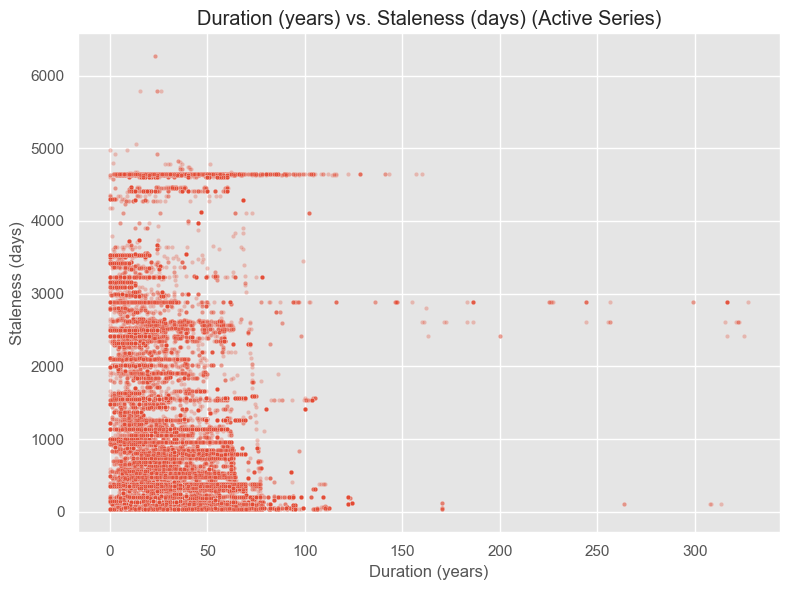

In [40]:
# Prepare data.
active = fred[fred["is_discontinued"] == False]
sample = active.sample(min(len(active), 700000), random_state=1)
# Plot.
caueduti.plot_scatterplot(
    df=sample,
    x="duration_years",
    y="staleness_days",
    alpha=0.3,
    s=10,
    title="Duration (years) vs. Staleness (days) (Active Series)",
    xlabel="Duration (years)",
    ylabel="Staleness (days)",
)

- **No clear “longer‑lived = fresher” trend** – series that have run for decades (100+ years) can be either very up‑to‑date or months/years stale, and short‐duration series likewise span the full staleness range.
- **High concentration of moderately stale data** – most series cluster with durations under 50 years and staleness around 0–5 years, indicating routine updates even for long‐running indicators.
- **Freshest series (<30 days old)** are predominantly shorter‐duration (≤20 years), suggesting new or recently rebooted series get updated promptly.
- **Outliers**:
  - A handful of very long‑running series (>200 years) show both extremely low staleness (kept current) and very high staleness (archived).
  - Several mid‑life series (~30–60 years) appear in the 6 000–9 000 days staleness band, highlighting neglected datasets that haven’t been refreshed in a decade or more.